 --------------------------------------------------------------------------

               Astra- A space charge tracking algorithm
                  Version 4.0 - macOS 64bit - Intel   
                        DESY,  Hamburg 2022          
                        Fri Mar 21 21:21:50 

     Parameter file is:  astra.in                                          
     TNSA SC Analysis                                                                

 Initialize element settings:
     neglecting space charge forces 

 --------------------------------------------------------------------------
 Aperture:

 --------------------------------------------------------------------------
 Cavity:

     Reading cavity field data from:      cav_fit_rescaled.csv                                                            
     field smoothing is applied
     Cavity Frequency               f =   0.1084     GHz
     maximum gradient                      12.00     MV/m
     at                              

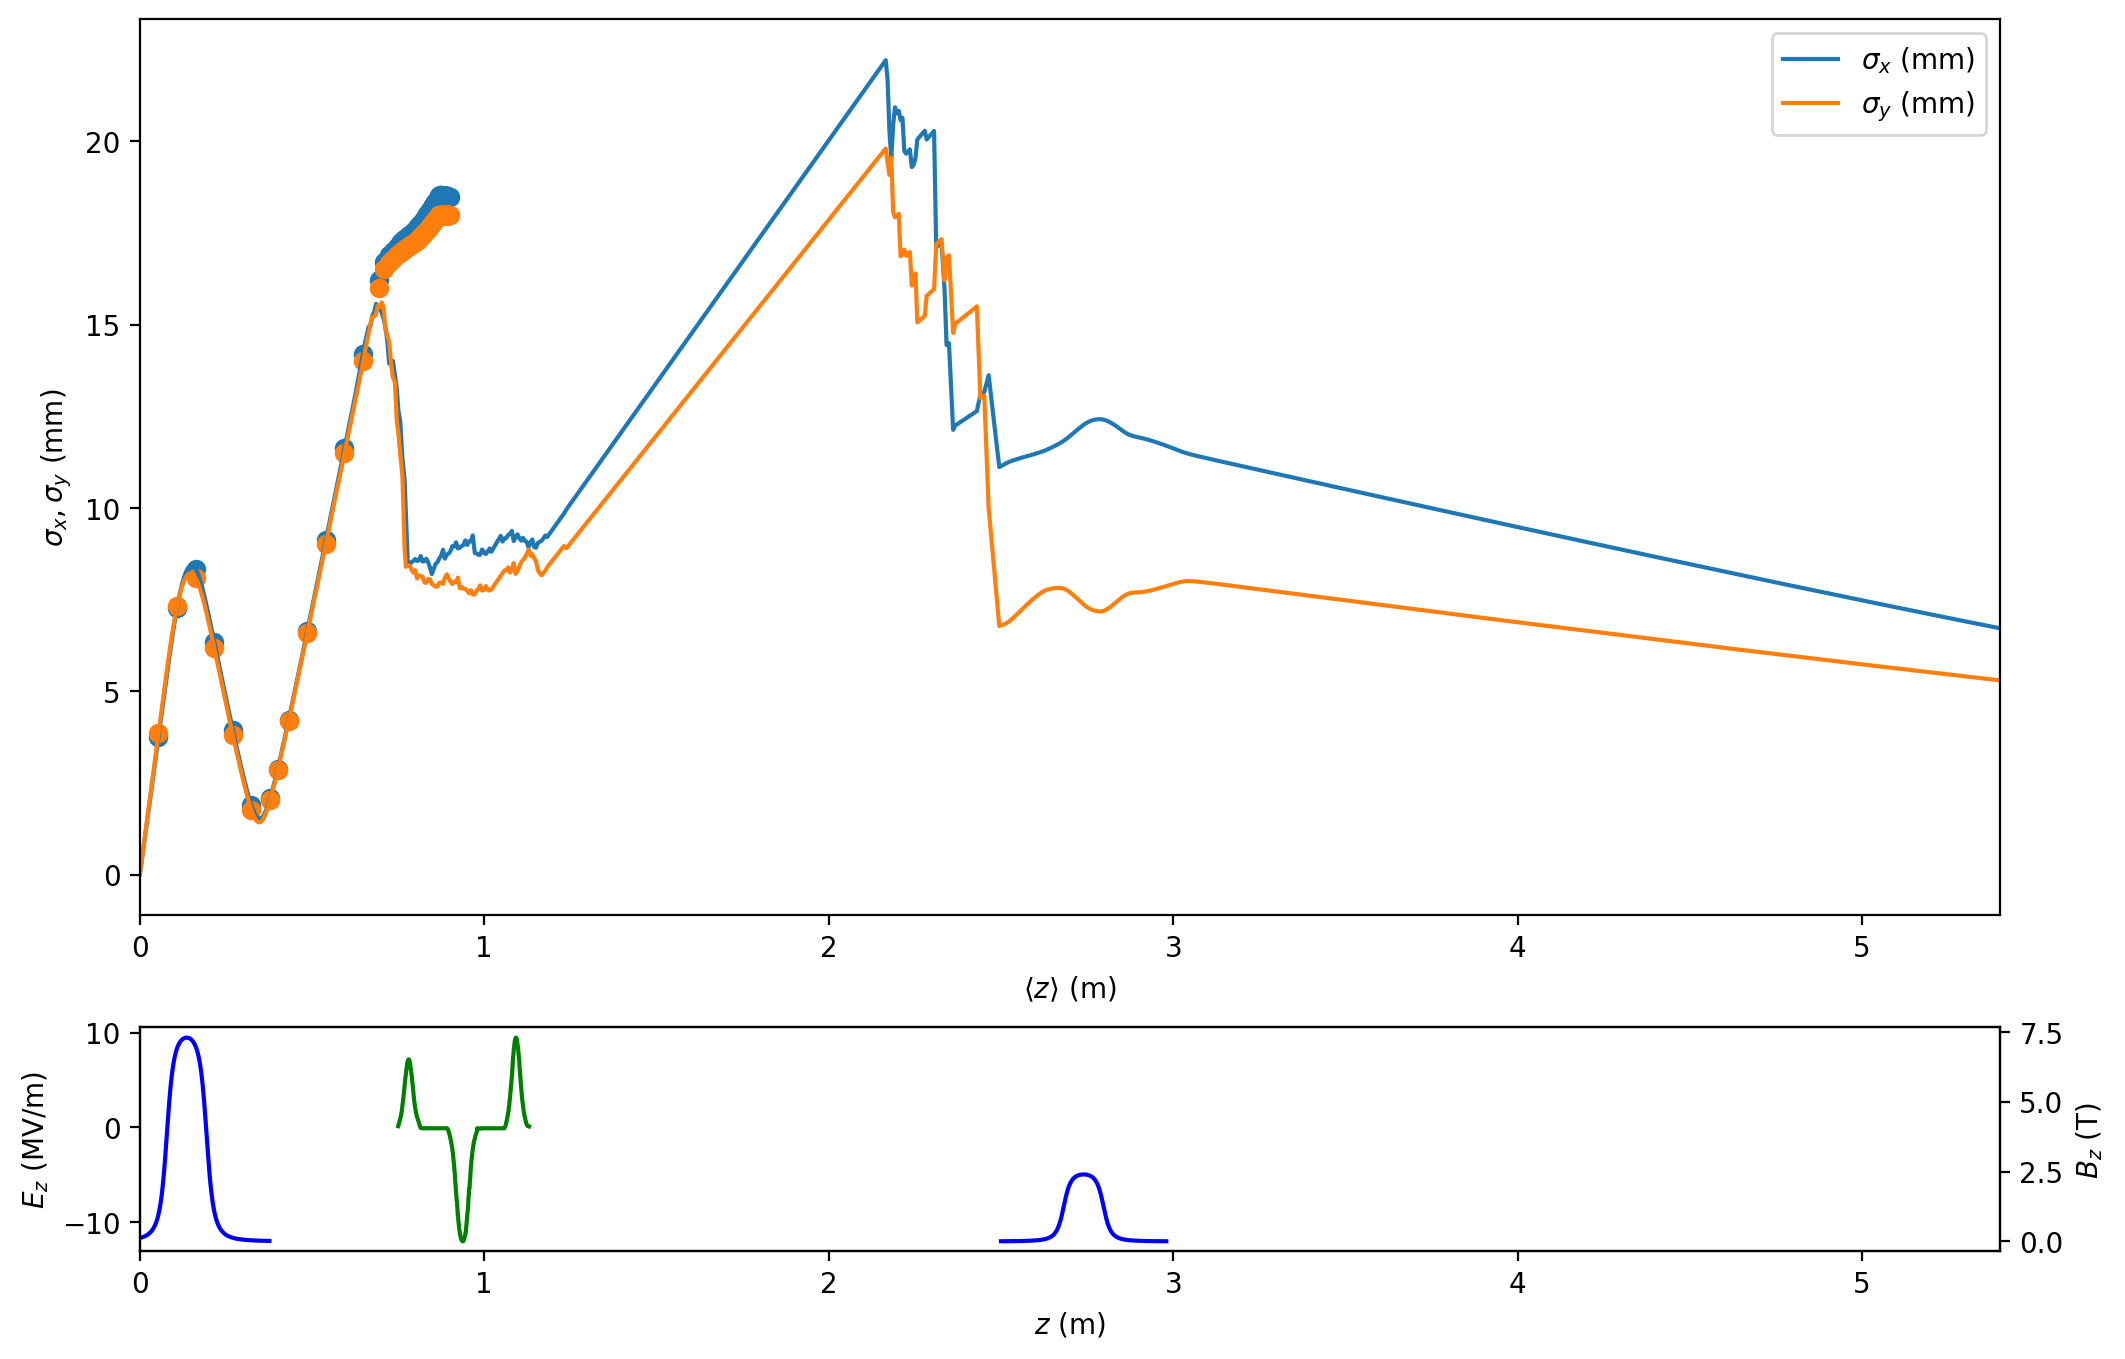

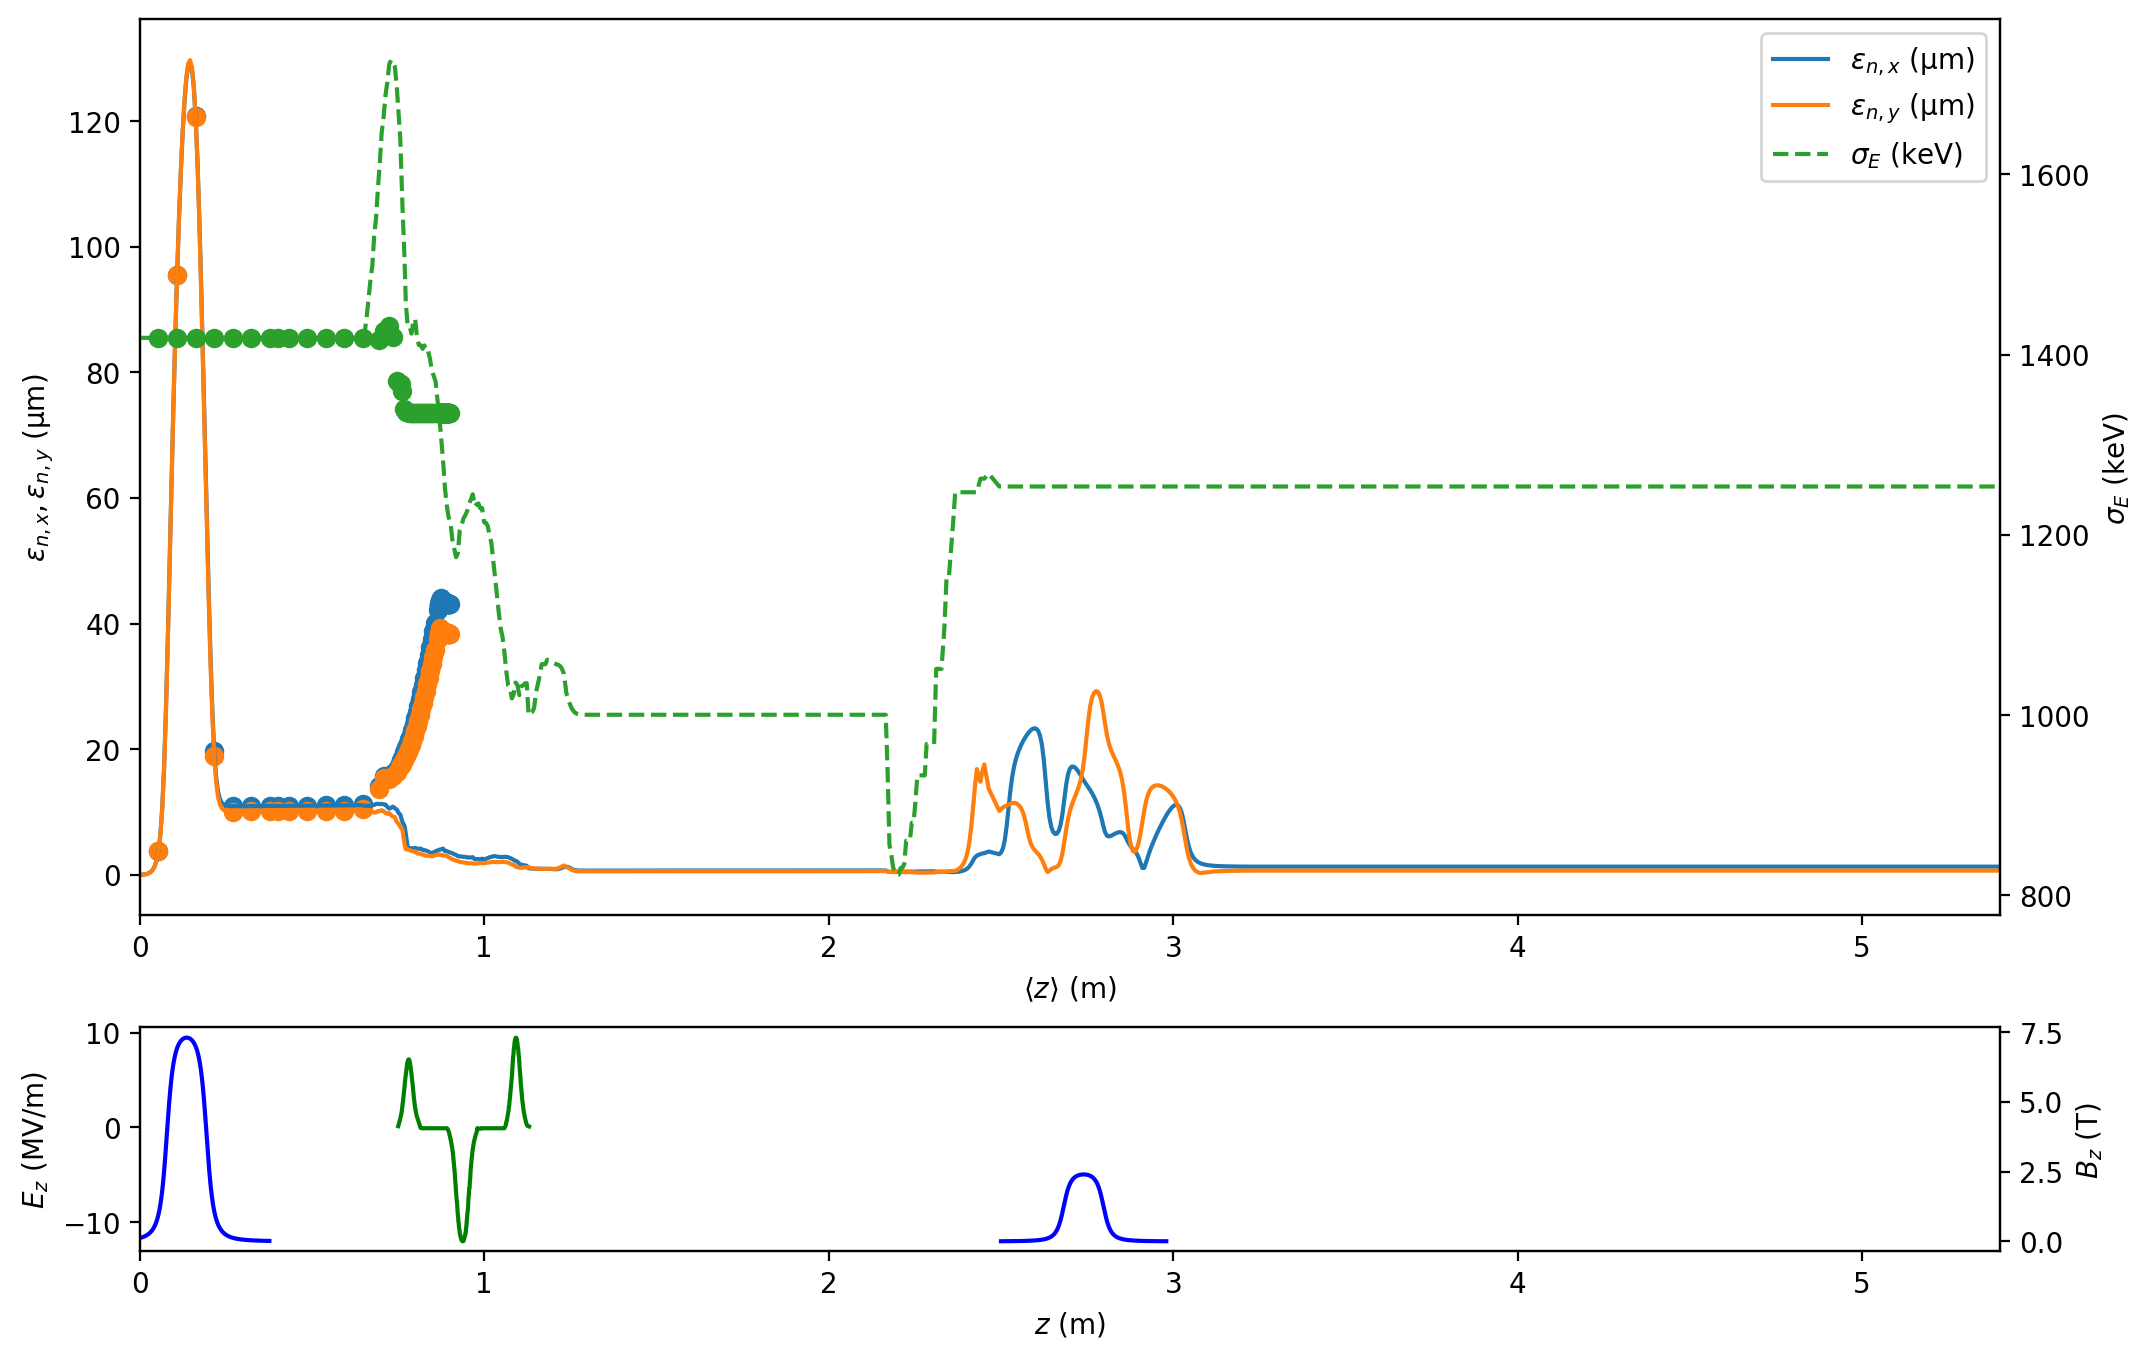

In [473]:
from astra import Astra

import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import CMethods
import scipy.constants as const

matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

A0 = Astra("astra.in")

b_field = 11.8
A0.input['solenoid']['MaxB(1)'] = b_field
A0.input['newrun']['zstop'] = 5.4
#A0.input['output']['M_Zlist'] = 4500
A0.input['aperture']['lapert'] = True
#A0.input['aperture']['Ap_Z1(1)'] = 0
#A0.input['aperture']['Ap_Z2(1)'] = 0.4



A0.timeout = None
A0.verbose = True

#Run<

A0.run()
A0.plot()
A0.plot(['norm_emit_x', 'norm_emit_y'], y2='sigma_energy', xlim = (0, 5.4), figsize=(12,8) )




In [362]:
#print(A0.output["stats"]["sigma_energy"][-1])
print(A0.output["stats"]["mean_x"][-1])

P = A0.output["particles"][-1]

print(P["n_particle"])
print(P["n_alive"])


-0.0013552
999
221


In [341]:
import astra_optimizer as ao

alpha_beamline = ao.Astra_SCS_Beamline("astra.in", [12, 2.8, 12, -60, 0.5, 1],True ,5.4)



In [342]:
alpha_beamline.run_simulation()

 --------------------------------------------------------------------------

               Astra- A space charge tracking algorithm
                  Version 4.0 - macOS 64bit - Intel   
                        DESY,  Hamburg 2022          
                        Tue Mar 18 15:00:33 

     Parameter file is:  astra.in                                          
     TNSA SC Analysis                                                                

 Initialize element settings:
     neglecting space charge forces 

 --------------------------------------------------------------------------
 Aperture:

 --------------------------------------------------------------------------
 Cavity:

     Reading cavity field data from:      cav_fit_rescaled.csv                                                            
     field smoothing is applied
     Cavity Frequency               f =   0.1084     GHz
     maximum gradient                      12.00     MV/m
     at                              

In [348]:
transm = alpha_beamline.get_sigma_energy_rel(-1)
print(transm)

0.00210653182348971


In [478]:
import pygad 

from astra import Astra
import astra_optimizer as ao

gs_i0 = {"low": 0, "high": 20}
gs_i1 = {"low": 0, "high": 20}
gs_u0 = {"low": 0, "high": 12}
gs_phi = {"low": 0, "high": 7}
gs_d01 = {"low": 0, "high": 2}
gs_d12 = {"low": 0, "high": 2}

beamline_chromosome = [gs_i0, gs_i1, gs_u0, gs_phi, gs_d01, gs_d12]

desired_output_transmission = 0.5
desired_output_sigma_energy = 0.001
desired_output_spot = 10

def fitness_func(ga_instance, solution, solution_idx):
    AGAD = ao.Astra_SCS_Beamline("astra.in", solution, True, 5.4)
    AGAD.run_simulation(verbose=False, timeout=None)
    transmission = AGAD.get_transmission(verb=False)
    sigma_energy = AGAD.get_sigma_energy_rel(-1)
    spot_size = AGAD.get_spot_size(-1)
    transmission_fitness = abs(transmission-desired_output_transmission)/desired_output_transmission
    sigma_energy_fitness = abs(sigma_energy-desired_output_sigma_energy)/desired_output_sigma_energy
    output_spot_fitness = abs(spot_size-desired_output_spot)/desired_output_spot
    
    return transmission/sigma_energy_fitness + transmission/output_spot_fitness

def on_generation(ga_instance):
    ga_instance.logger.info(f"Generation = {ga_instance.generations_completed}")
    ga_instance.logger.info(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    if ga_instance.generations_completed%10==0:
        ga_instance.logger.info(f"Solution    = {ga_instance.best_solution()[0]}")
    
fitness_function = fitness_func



num_generations = 100
num_parents_mating = 20

sol_per_pop = 20
num_genes = len(beamline_chromosome)

#init_range_low = -2
#init_range_high = 5

parent_selection_type = "sss"
keep_parents = -1

crossover_type = "two_points"

mutation_type = "random"
mutation_probability = 0.4
mutation_percent_genes = 20

random_mutation_min_val = -2
random_mutation_max_val = 2

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       on_generation=on_generation,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       mutation_percent_genes=mutation_percent_genes,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       gene_space=beamline_chromosome,
                       parallel_processing=8)

ga_instance.run()


Generation = 1
Fitness    = 0.48429346313536464
Generation = 2
Fitness    = 0.48429346313536464
Generation = 3
Fitness    = 0.48429346313536464
Generation = 4
Fitness    = 0.48429346313536464
Generation = 5
Fitness    = 0.48429346313536464
Generation = 6
Fitness    = 1.4955632263659504
Generation = 7
Fitness    = 1.4955632263659504
Generation = 8
Fitness    = 2.9115776884354694
Generation = 9
Fitness    = 409.6213251192397
Generation = 10
Fitness    = 409.6213251192397
Solution    = [9.68043259 2.13110297 4.47100435 0.86423622 0.20692111 1.31313634]
Generation = 11
Fitness    = 409.6213251192397
Generation = 12
Fitness    = 409.6213251192397
Generation = 13
Fitness    = 409.6213251192397
Generation = 14
Fitness    = 409.6213251192397
Generation = 15
Fitness    = 409.6213251192397
Generation = 16
Fitness    = 409.6213251192397
Generation = 17
Fitness    = 409.6213251192397
Generation = 18
Fitness    = 409.6213251192397
Generation = 19
Fitness    = 409.6213251192397
Generation = 20
Fitne

In [496]:
import pickle

evolution_list = []

for i in range(1, 11):
    temp_evo = ao.evolution_run(100, 50, 50, "random", i/10)
    evolution_list.append(temp_evo)
    
file = open("genetic_trials/mutation_variation_1.pickle", "wb")
pickle.dump(evolution_list, file)
file.close()



Generation = 1
Fitness    = 4.961029648873288
Generation = 2
Fitness    = 4.961029648873288
Generation = 3
Fitness    = 4.961029648873288
Generation = 4
Fitness    = 14.765292392233585
Generation = 5
Fitness    = 14.765292392233585
Generation = 6
Fitness    = 35.372574688268415
Generation = 7
Fitness    = 35.372574688268415
Generation = 8
Fitness    = 35.372574688268415
Generation = 9
Fitness    = 35.372574688268415
Generation = 10
Fitness    = 35.372574688268415
Solution    = [11.48370322  4.08608991  0.95517007  5.34865296  1.02522272  1.30311439]
Generation = 11
Fitness    = 35.372574688268415
Generation = 12
Fitness    = 35.372574688268415
Generation = 13
Fitness    = 54.91433908435689
Generation = 14
Fitness    = 54.91433908435689
Generation = 15
Fitness    = 54.91433908435689
Generation = 16
Fitness    = 54.91433908435689
Generation = 17
Fitness    = 54.91433908435689
Generation = 18
Fitness    = 54.91433908435689
Generation = 19
Fitness    = 55.486932705481664
Generation = 20
Fi

In [494]:
file_open = open("genetic_trials/mutation_variation.pickle", "rb")
test_reloaded = pickle.load(file_open)
file_open.close()

print(test_reloaded[0].best_solution()[0])
print(test_reloaded[1].best_solution()[0])



[11.01166974  3.64082222  5.70912072  6.20204787  1.79663567  1.54411138]
[10.51098957  2.79163714  5.36206705  3.7109967   1.20757791  1.10993595]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


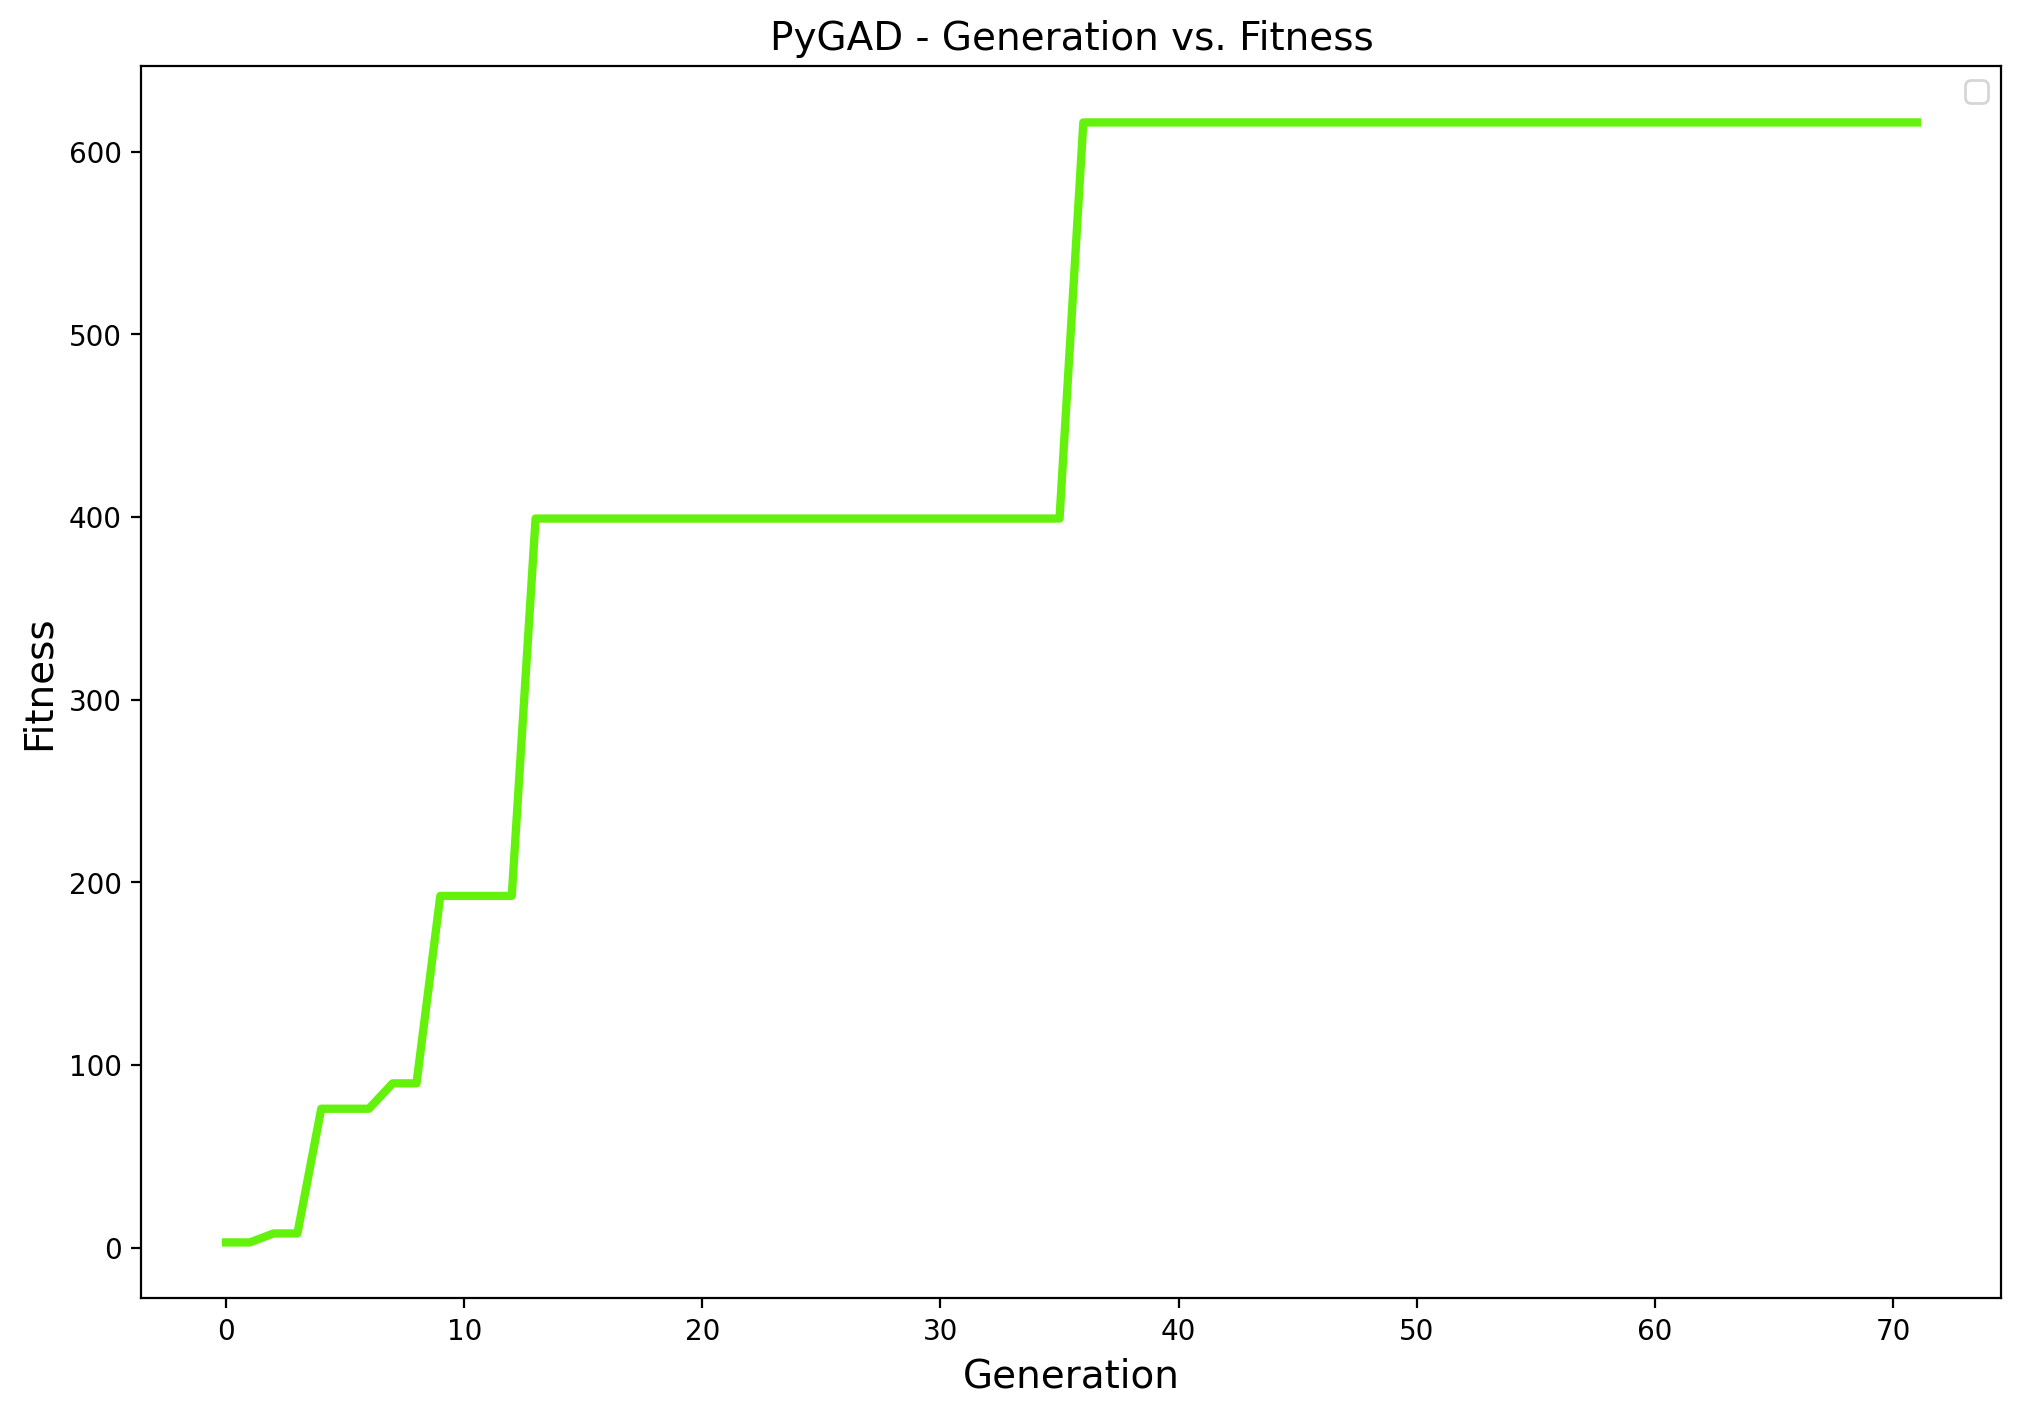

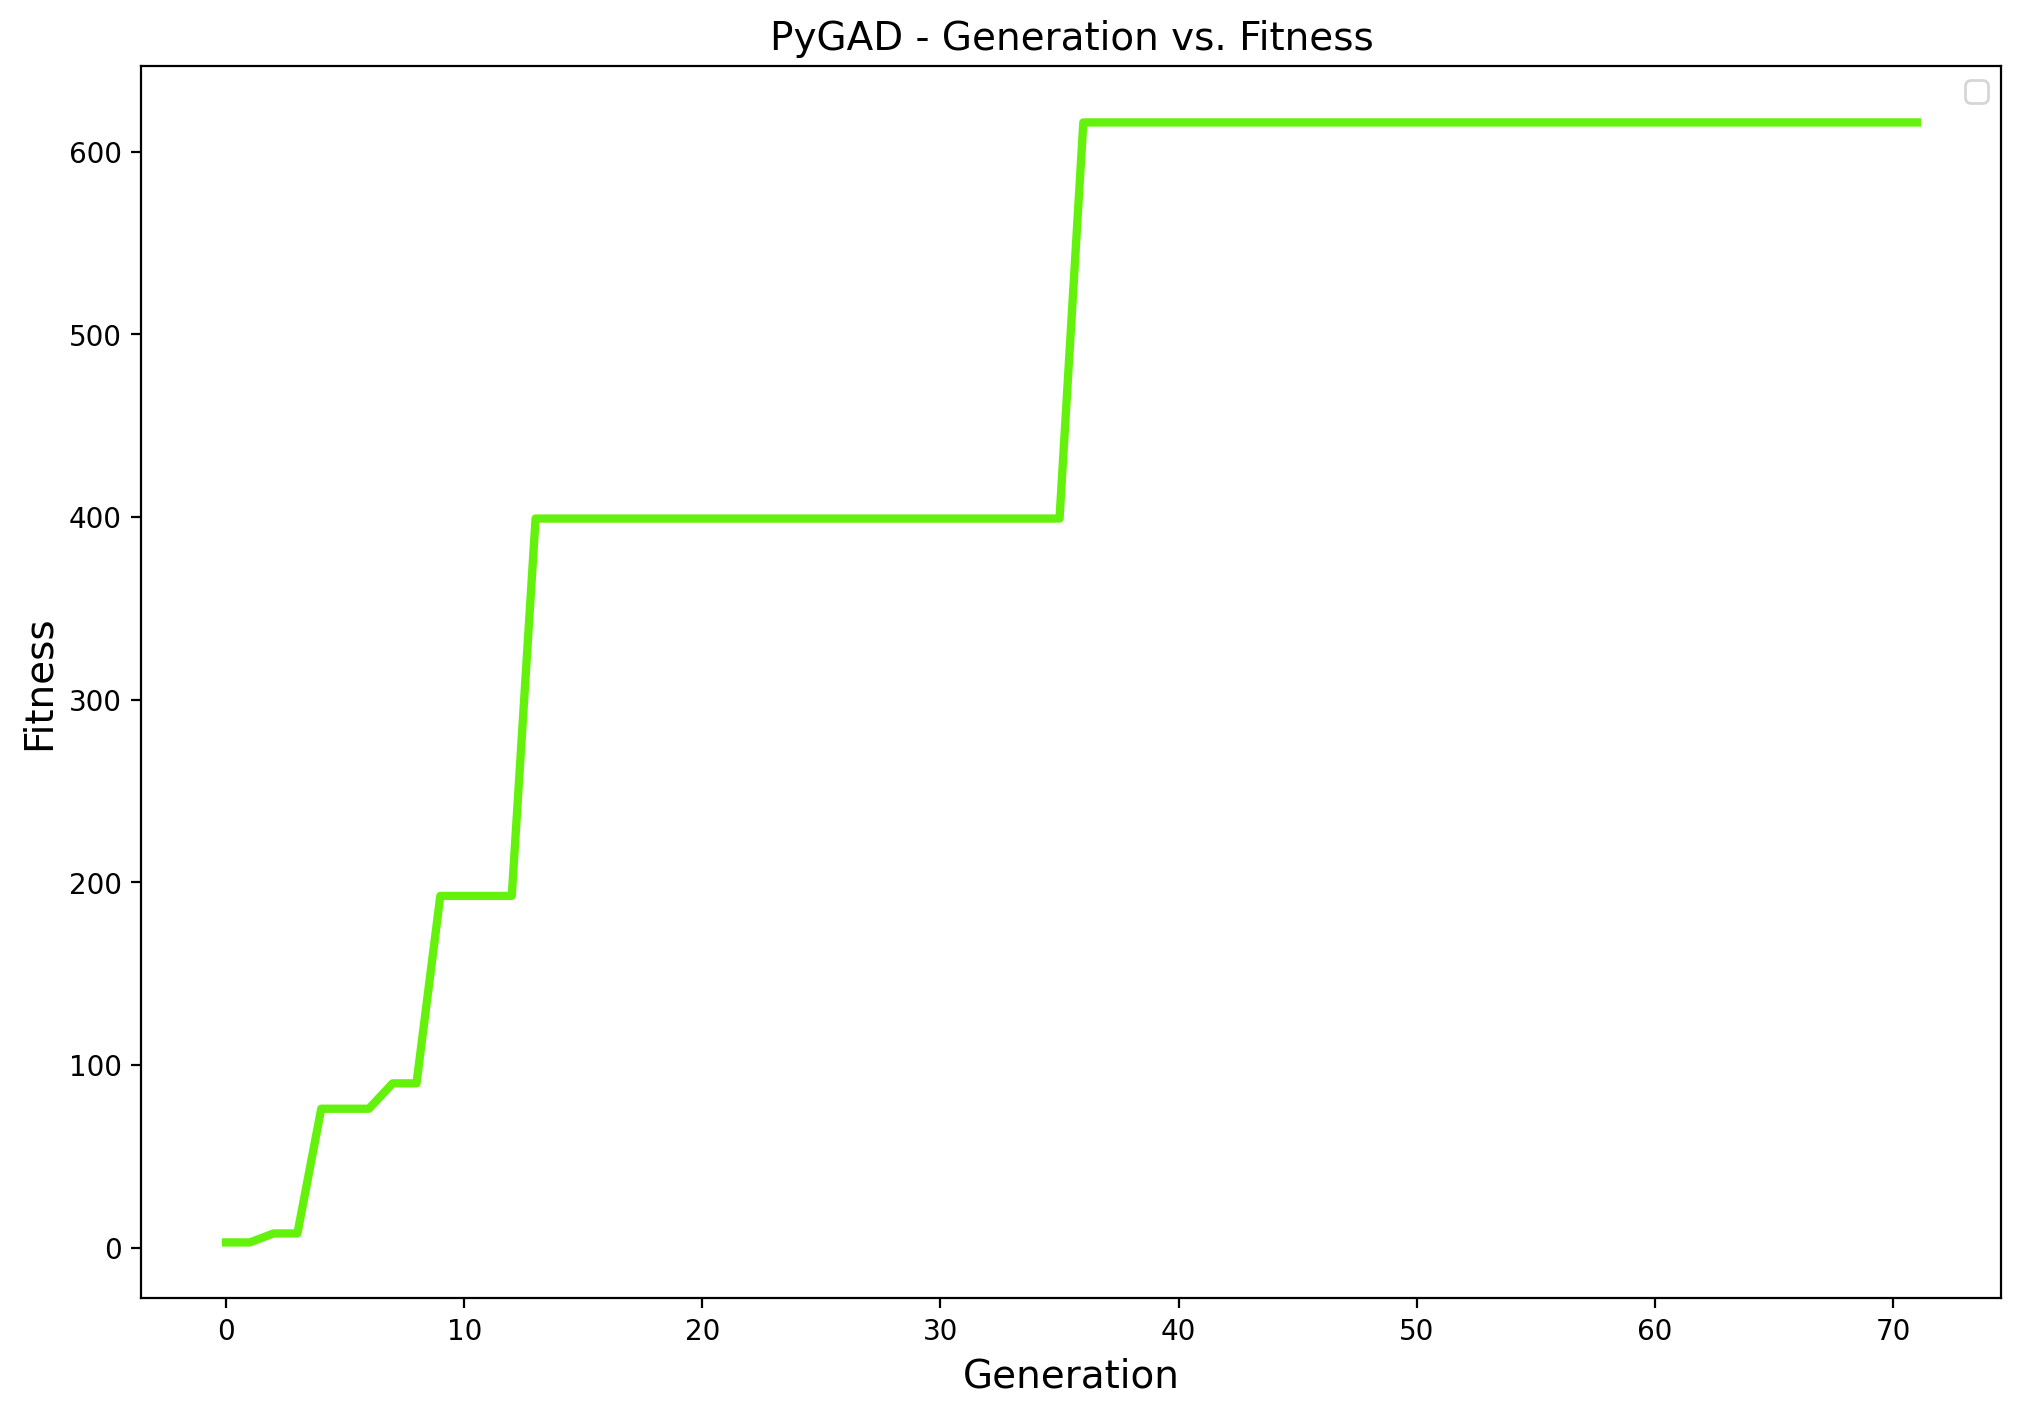

In [423]:
ga_instance.plot_fitness()

In [433]:
best_solution = ga_instance.best_solution()[0]

for solution in best_solution:
    print(solution)

10.774097894282185
2.88706736698785
7.840269709054642
5.918912190503936
0.4189995591213993
1.492968435015989


In [465]:
import scipy as sp

#base_chromosome = [best_solution[0], best_solution[1], best_solution[2], best_solution[3], best_solution[4], best_solution[5]]
base_chromosome = [10.50937642,  2.62828272, 12.9210557 ,  7.18772745,  0.48957234, 1.3163509]

def min_function(beamline_chromosome):
    ABFGS = ao.Astra_SCS_Beamline("astra.in", beamline_chromosome, True, 5.4)
    ABFGS.run_simulation(verbose=False, timeout=None)
    transmission = ABFGS.get_transmission(verb=False)
    sigma_energy = ABFGS.get_sigma_energy_rel(-1)
    spot_size = ABFGS.get_spot_size(-1)/1000
    output_slope = ABFGS.get_var_at_exit(100)

    return (1-transmission) + 5*sigma_energy + spot_size + output_slope

res = sp.optimize.minimize(min_function, base_chromosome, method="COBYLA",
                           options={'gtol': 1e-9, 'disp': True})

res.x





   Normal return from subroutine COBYLA


array([10.50937642,  2.62828272, 12.9210557 ,  7.18772745,  0.48957234,
        1.3163509 ])

   NFVALS =   65   F = 7.082302E-01    MAXCV = 0.000000E+00
   X = 1.050938E+01   2.628283E+00   1.292106E+01   7.187727E+00   4.895723E-01
       1.316351E+00


In [ ]:
mutation_type = "random"
mutation_probability = 0.3
mutation_percent_genes = 20




In [389]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))



Parameters of the best solution : [  8.46708862   1.67571623   6.54087282 267.20117349   1.00648887
   1.12933038]
Fitness value of the best solution = [1.06163656e+00 8.86917038e-03 2.93389187e+04]


 --------------------------------------------------------------------------

               Astra- A space charge tracking algorithm
                  Version 4.0 - macOS 64bit - Intel   
                        DESY,  Hamburg 2022          
                        Sat Mar 22 14:19:01 

     Parameter file is:  astra.in                                          
     TNSA SC Analysis                                                                

 Initialize element settings:
     neglecting space charge forces 

 --------------------------------------------------------------------------
 Aperture:

 --------------------------------------------------------------------------
 Cavity:

     Reading cavity field data from:      cav_fit_rescaled.csv                                                            
     field smoothing is applied
     Cavity Frequency               f =   0.1084     GHz
     maximum gradient                     0.5358     MV/m
     at                              

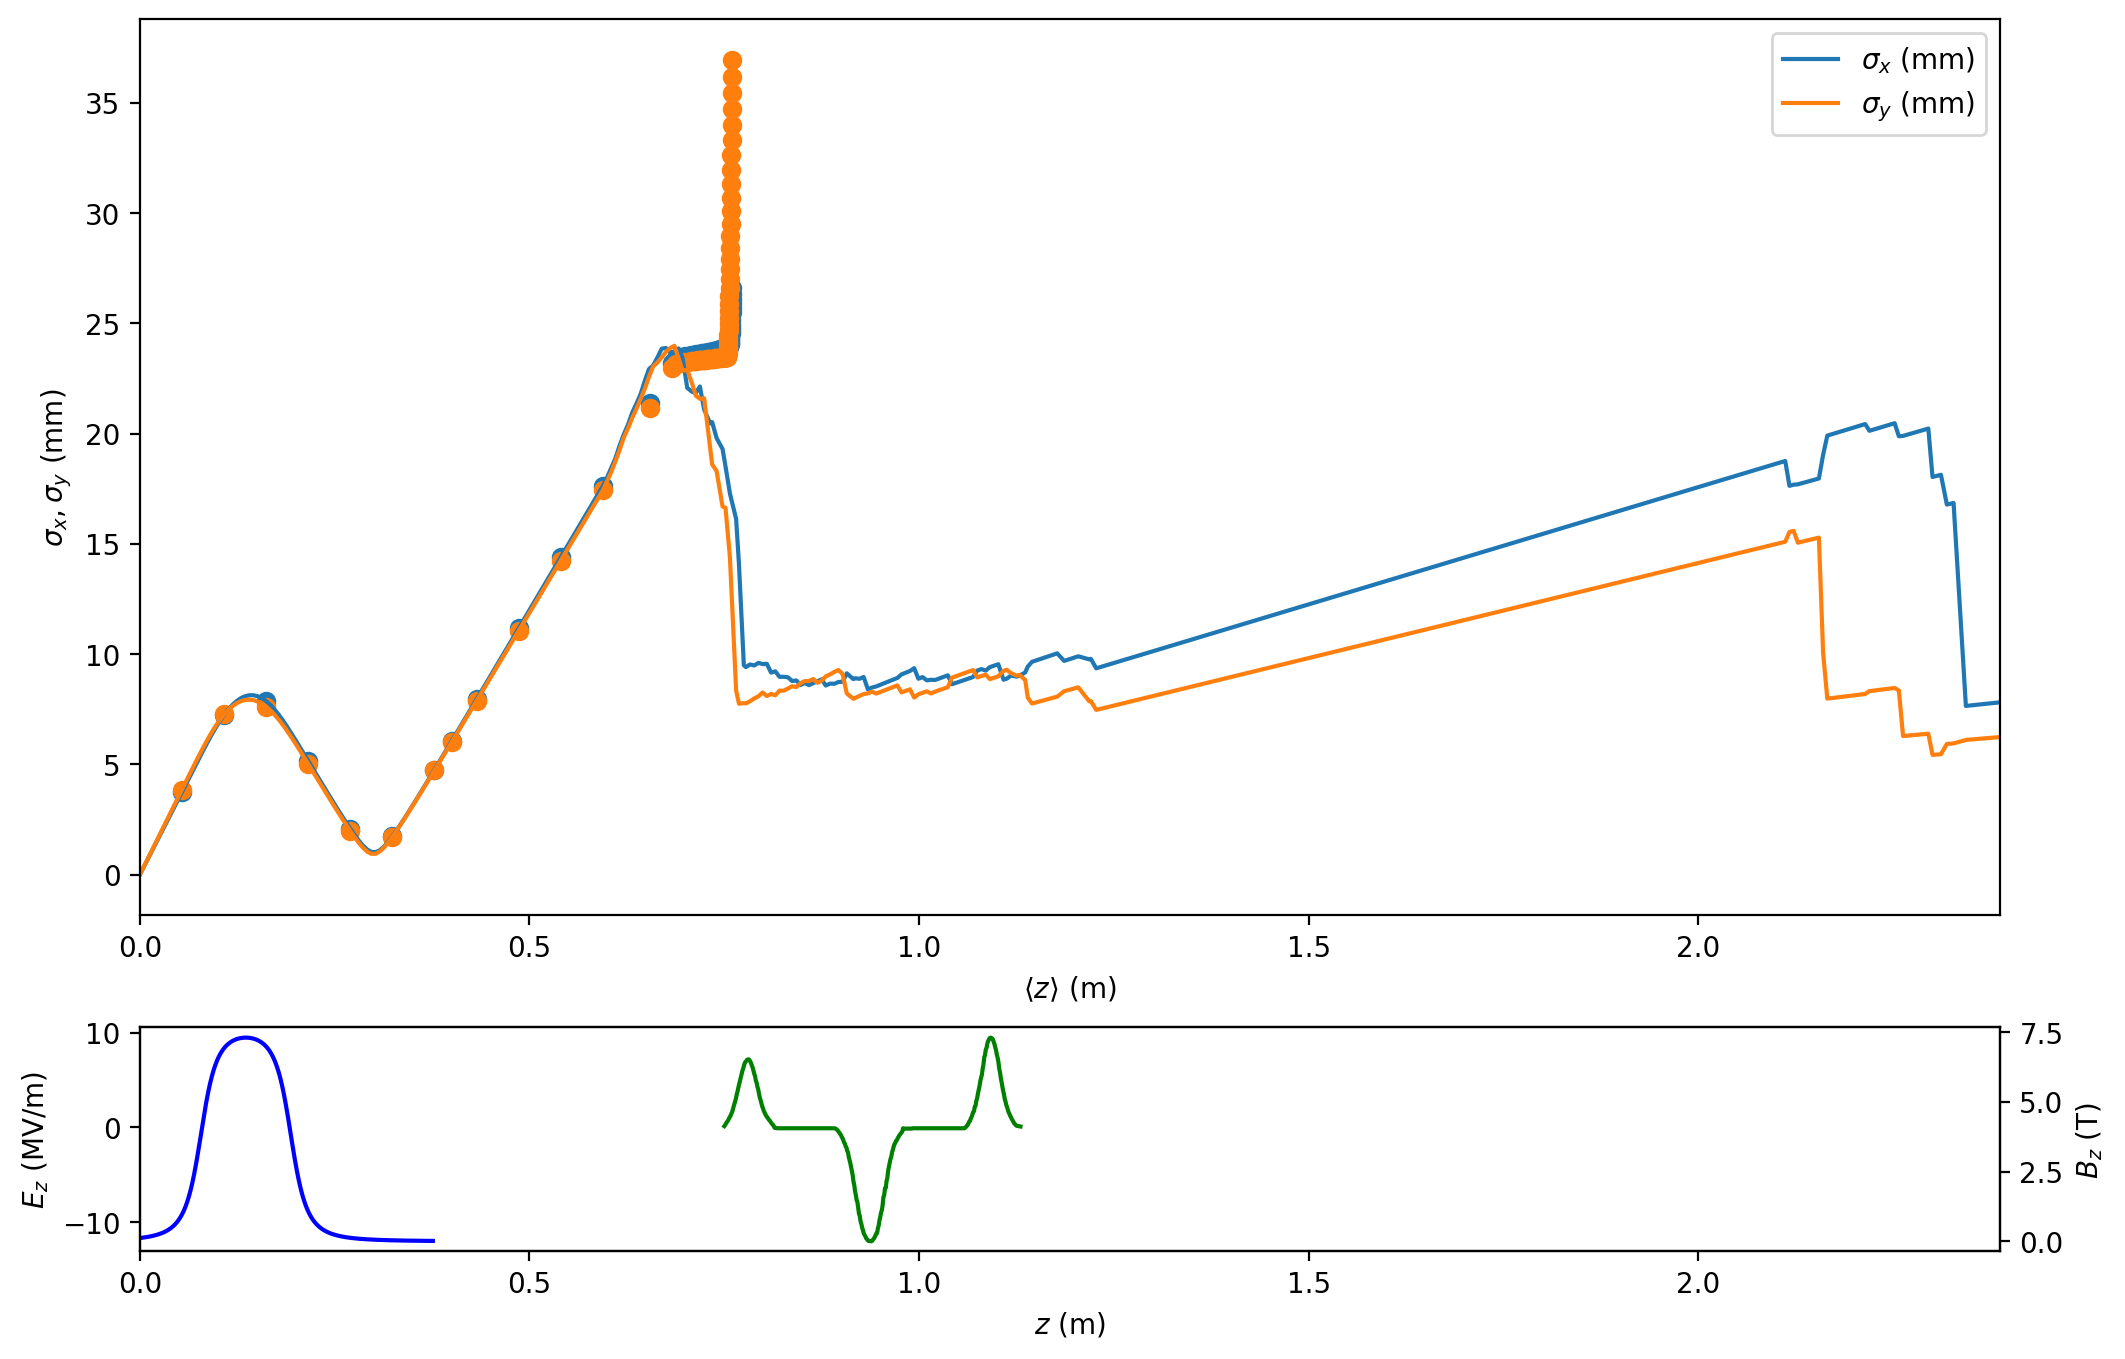

In [498]:

alpha_beamline = ao.AstraSCSBeamline("astra.in", [15.12416812, 14.55446046,  0.53576624,  3.18543733,  1.58306234,  1.10828047],True ,5.4)
alpha_beamline.run_simulation()

alpha_beamline.envelope_plot()

print(alpha_beamline.get_var_at_exit(200))
print(alpha_beamline.get_spot_size(-1))

In [ ]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = matplotlib.colormaps.get_cmap('inferno')

skip=1
X = np.array([P0.x for P0 in  A0.particles]).T[::skip]
Y = np.array([P0.y for P0 in  A0.particles]).T[::skip]
Z = np.array([P0.z for P0 in  A0.particles]).T[::skip]

scale = np.hypot(X[:, 0], Y[:,0]).max()

# color by  initial radius
for i in range(len(X)):
    color = cmap(1-np.hypot(X[i,0], Y[i,0])/scale)
    ax.plot(X[i]*1e3, Y[i]*1e3, Z[i], zdir='x', color=color, linewidth=.3)

ax.set_box_aspect((2,1,1))    
    
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (mm)')
ax.set_zlabel('Y (mm)')

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = matplotlib.colormaps.get_cmap('inferno')

skip=1
X = np.array([P0.x for P0 in  A1.particles]).T[::skip]
Y = np.array([P0.y for P0 in  A1.particles]).T[::skip]
Z = np.array([P0.z for P0 in  A1.particles]).T[::skip]

scale = np.hypot(X[:, 0], Y[:,0]).max()

# color by  initial radius
for i in range(len(X)):
    color = cmap(1-np.hypot(X[i,0], Y[i,0])/scale)
    ax.plot(X[i]*1e3, Y[i]*1e3, Z[i], zdir='x', color=color, linewidth=.3)

ax.set_box_aspect((2,1,1))    
    
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (mm)')
ax.set_zlabel('Y (mm)')

In [139]:
%load_ext autoreload
%autoreload 2
import CMethods
import torch
import numpy as np
import elements



ein_beam = elements.Beam("ltt_beam_export.part")

#print(len(ein_beam.bunch_list[0]))




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reference beta:0.15184108126537454, energy: 11.006966504345655


In [155]:

import elements

reference_energy = 11.006966504345655

reference_beta = CMethods.beta(reference_energy, "proton")

#9.1826, 3.6575, 1.3233, 0.7451, 2.1488, 5.1281
#k_set = torch.tensor([10, 3, 1, 3], dtype=torch.float64)
#k_set = torch.tensor([9.92, 3.3, 0.45, 1.87, 1 , 0], dtype=torch.float64)
#k_set = torch.tensor([6, 6, 1, 0], dtype=torch.float64)
#k_set = torch.tensor([9.2664, 3.9788, 0.6625, 1.2778, 0.5394, 1.5409], dtype=torch.float64)
#k_set = torch.tensor([6.5187,  2.5999, 1.5433], dtype=torch.float64)
#k_set = torch.tensor([8.3218, 3.4857, 0.3457, 1.3777, 0.5237, 1.5400], dtype=torch.float64)
#k_set = torch.tensor([8.0605e+00, 2.2530e+00, 4.6433e-05, 1.3307e-06, 1.9590e-01, 1.5094e+00], dtype=torch.float64)
#k_set = torch.tensor([9.1099e+00, 2.2733e+00, 2.7564e-03, 5.5848e-01, 9.4987e-01, 1.5387e+00], dtype=torch.float64)
#k_set = torch.tensor([ 9.8973e+00,  2.0279e+00,  3.4721e-05, -1.1535e-04,  2.9250e-02, 1.1848e+00,  9.3790e-01,  6.5230e-01, 2.9781e+00], dtype=torch.float64)

#k_set = torch.tensor([5.7121e+00, 1.5556e+00, 4.5861e-04, 1.6914e+00, 1.5899e-01, 1.5327e+00], dtype=torch.float64) #4 MeV
#k_set = torch.tensor([7.0302e+00,  1.9156e+00, -7.4734e-04,  1.4947e+00,  2.9203e-01, 1.5328e+00], dtype=torch.float64) #6 MeV
#k_set = torch.tensor([7.5314e+00, 1.9970e+00, 7.0824e-03, 1.4279e+00, 3.6861e-01, 1.5394e+00], dtype=torch.float64) #7.03 MeV
#k_set = torch.tensor([8.0574e+00,  2.1308e+00, -1.5691e-04,  1.4069e+00,  4.4115e-01, 1.5387e+00], dtype=torch.float64) #8 MeV
#k_set = torch.tensor([8.5288e+00,  2.2385e+00, -6.0227e-05,  1.3206e+00,  5.2996e-01, 1.5345e+00], dtype=torch.float64) #9.01 MeV
#k_set = torch.tensor([9.0196e+00,  2.4141e+00, -2.6359e-03,  1.2616e+00,  6.2043e-01, 1.5335e+00], dtype=torch.float64) #10 MeV
#k_set = torch.tensor([9.7708e+00,  2.4133e+00, -6.1862e-06,  1.2340e+00,  8.0504e-01, 1.5487e+00], dtype=torch.float64) #12 MeV
#k_set = torch.tensor([1.0680e+01, 2.9506e+00, 1.1849e-05, 1.0425e+00, 1.0129e+00, 1.5387e+00], dtype=torch.float64) #14 MeV
#k_set = torch.tensor([1.1394e+01,  3.1499e+00, -4.2410e-05,  9.8942e-01,  1.2169e+00, 1.5362e+00], dtype=torch.float64) #15.83 MeV
k_set = torch.tensor([71,  0, -2.6359e-03,  1.2616e+00,  6.2043e-01, 1.5335e+00], dtype=torch.float64) #10 MeV

#tensor([ 9.2689e+00,  2.3133e+00, -3.3649e-04,  2.1081e-04, -1.4374e-04,
#         1.2876e+00,  1.0629e+00, -5.7086e-01, -8.2948e-02],
#       dtype=torch.float64, requires_grad=True)

# Optimization#
model = elements.LatticeOptimizer(k_set, "ltt_beam_export.part", ref_energy=reference_energy)

params, loss = elements.train_model(model, 1000, .01)



par : Parameter containing:
tensor([ 7.1000e+01,  0.0000e+00, -2.6359e-03,  1.2616e+00,  6.2043e-01,
         1.5335e+00], dtype=torch.float64, requires_grad=True)
Iter 1/1000 - Loss: nan 
Parameters: par : Parameter containing:
tensor([nan, nan, nan, nan, nan, nan], dtype=torch.float64, requires_grad=True)
Gradients: par : tensor([nan, nan, nan, nan, nan, nan], dtype=torch.float64)


KeyboardInterrupt: 

In [1]:
import elements
import CMethods
%load_ext autoreload
%autoreload 2

reference_energy = 4.664318356136619
reference_beta = CMethods.beta(reference_energy, "proton")

test_beam = elements.Beam("ltt_beam_export.part")


Reference momentum:93450443.2676332


999


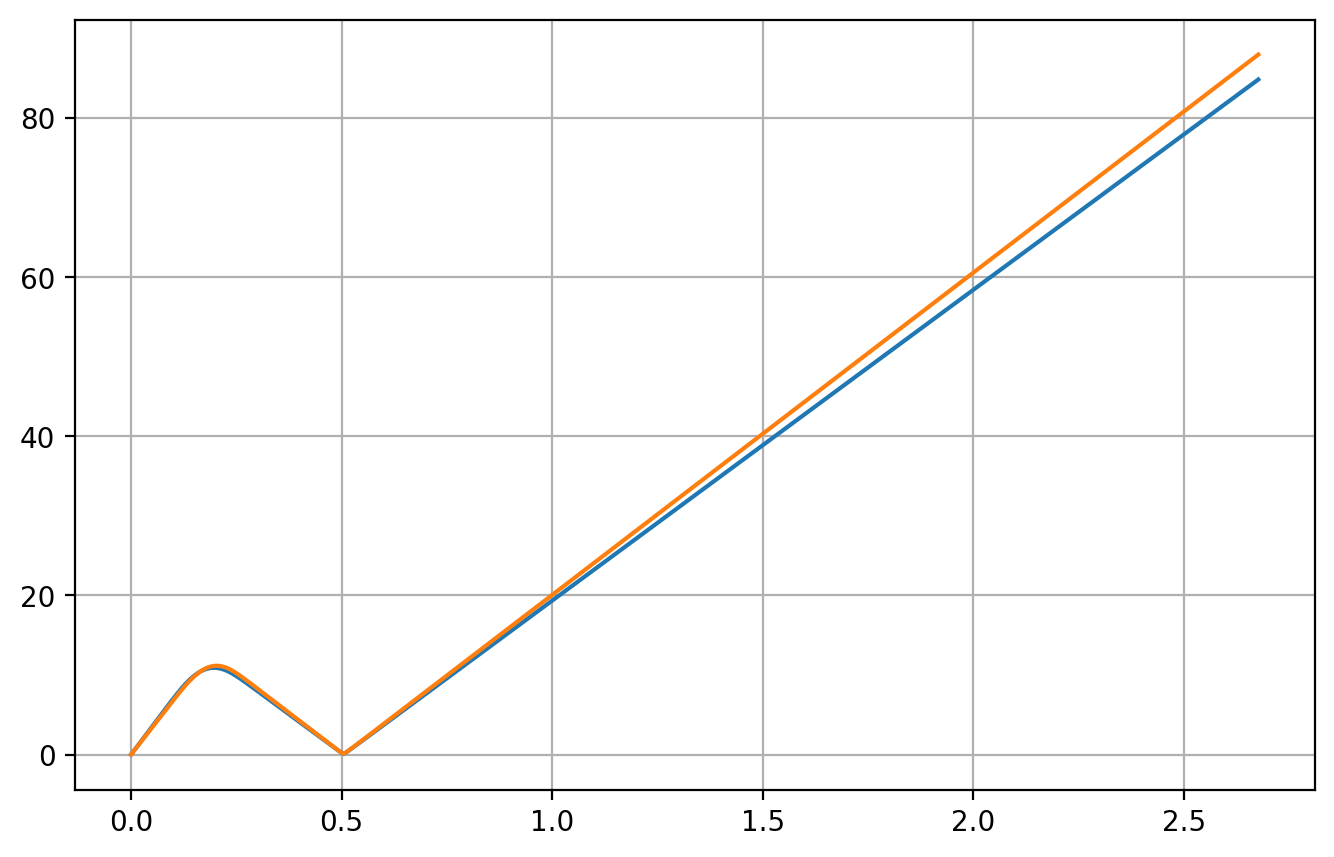

In [215]:

import matplotlib

import matplotlib.pyplot as plt
from importlib import reload
reference_energy = 11.006966504345655
reference_beta = CMethods.beta(reference_energy, "proton")

matplotlib.rcParams['figure.figsize'] = (8,5)
%config InlineBackend.figure_format = 'retina'

#test_beam.reset_beam()

test_beam = elements.Beam("ltt_beam_export.part")

#[x,y,z] = elements.toy_model(11.4741, 2.5080, 0.0796, 3.6547, test_particles_xyz)
#[x,y,z] = elements.toy_model(9.2325, 1.8927, 0.0863, 2.9702, test_particles_xyz)
#[x,y,z] = elements.toy_model(9.7, 3.6, 0, 4, test_beam)
#elements.toy_model(9.7, 3.6, 0, 4, test_beam, aperture=False)
#elements.toy_model(9.8128, 5.1838, 0.6912, 3.2449, 0.5516, 1.5510, test_beam, aperture=False, ref_energy=10.198793622348148)
#elements.toy_model(9.1378e+00, 2.2096e+00, 2.7965e-06, 1.5511e-06, 1.2954e-06, 1.2203e+00, 1.0646e+00, 5.3939e-01, 3.0493e+00, test_beam, aperture=True, ref_energy=reference_energy)

elements.toy_model(12,  0, -9.4006e-04,  8.7581e-01,  8.0301e-01, 1.5633e+00, test_beam, aperture=False, ref_energy=reference_energy)
#elements.toy_model(9.02, 2.5941, 0.0117, 1.6760, 1.06, 1.5444, test_beam, aperture=True, ref_energy=reference_energy)


rms_plt_test = [test_beam.rms_x.clone(), test_beam.rms_y.clone(), test_beam.z_pos.clone()]

plt.plot(rms_plt_test[2].detach().clone(), rms_plt_test[0].detach().clone()*1000)
plt.plot(rms_plt_test[2].detach().clone(), rms_plt_test[1].detach().clone()*1000)

print(len(test_beam.bunch_list[-1]))

#reload(plt)

plt.grid()
plt.show()



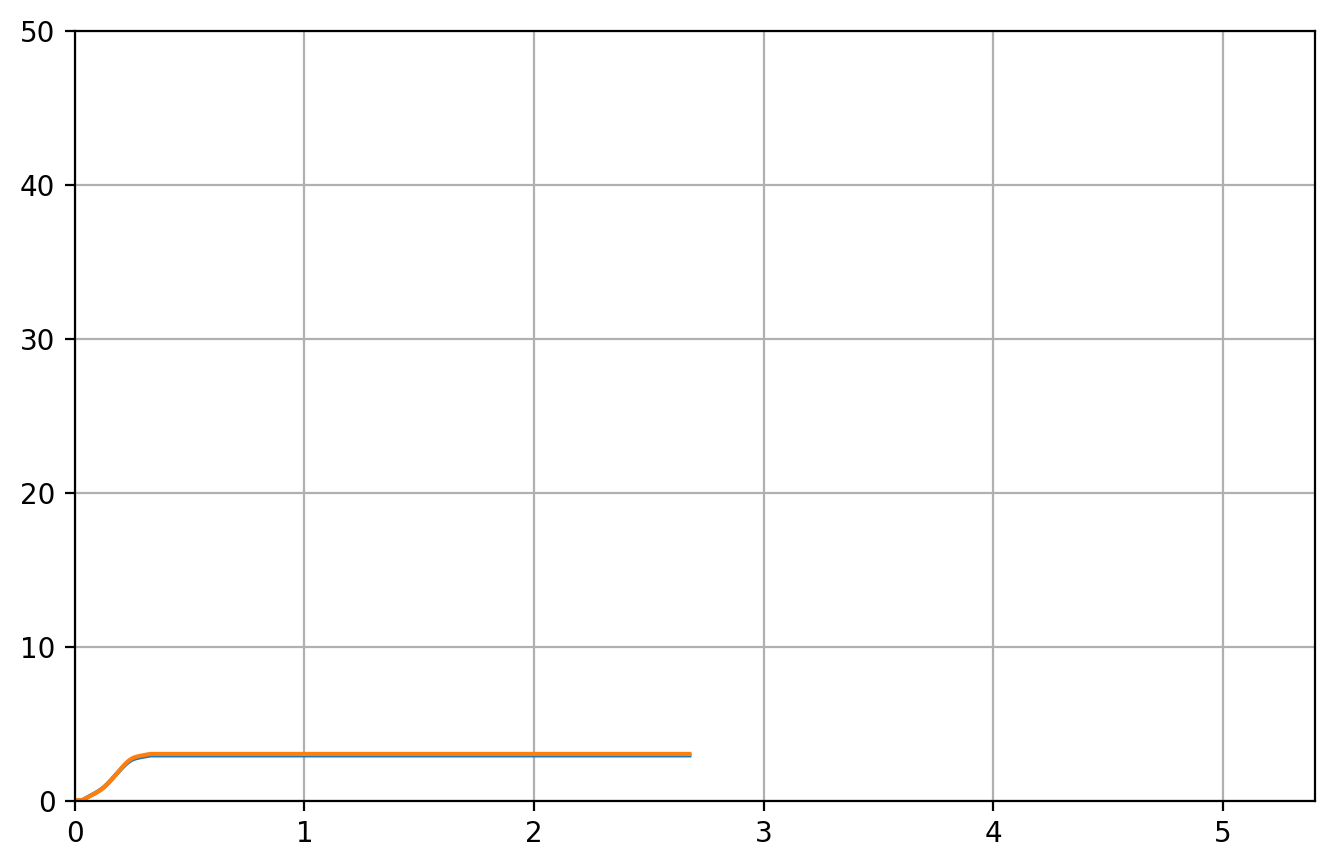

In [216]:
eps_plt_test = test_beam.eps_x.clone()
eps_plt_test_y = test_beam.eps_y.clone()

ref_energy = reference_energy
beta_ref = CMethods.beta(ref_energy, "proton")
gamma_ref = CMethods.beta_to_gamma(beta_ref)

emit_mmmrad = 10**6 * eps_plt_test.detach().clone()
emit_mmmrad_norm = beta_ref*gamma_ref*emit_mmmrad
emit_mmmrad_norm_2rho =4 * emit_mmmrad_norm

emit_mmmrad_y = 10**6 * eps_plt_test_y.detach().clone()
emit_mmmrad_norm_y = beta_ref*gamma_ref*emit_mmmrad_y
emit_mmmrad_norm_2rho_y =4 * emit_mmmrad_norm_y

plt.plot(rms_plt_test[2].detach().clone(), emit_mmmrad_norm_2rho)
plt.plot(rms_plt_test[2].detach().clone(), emit_mmmrad_norm_2rho_y)
plt.xlim([0,5.4])
plt.ylim([0,50])

#reload(plt)

plt.grid()
plt.show()



50675


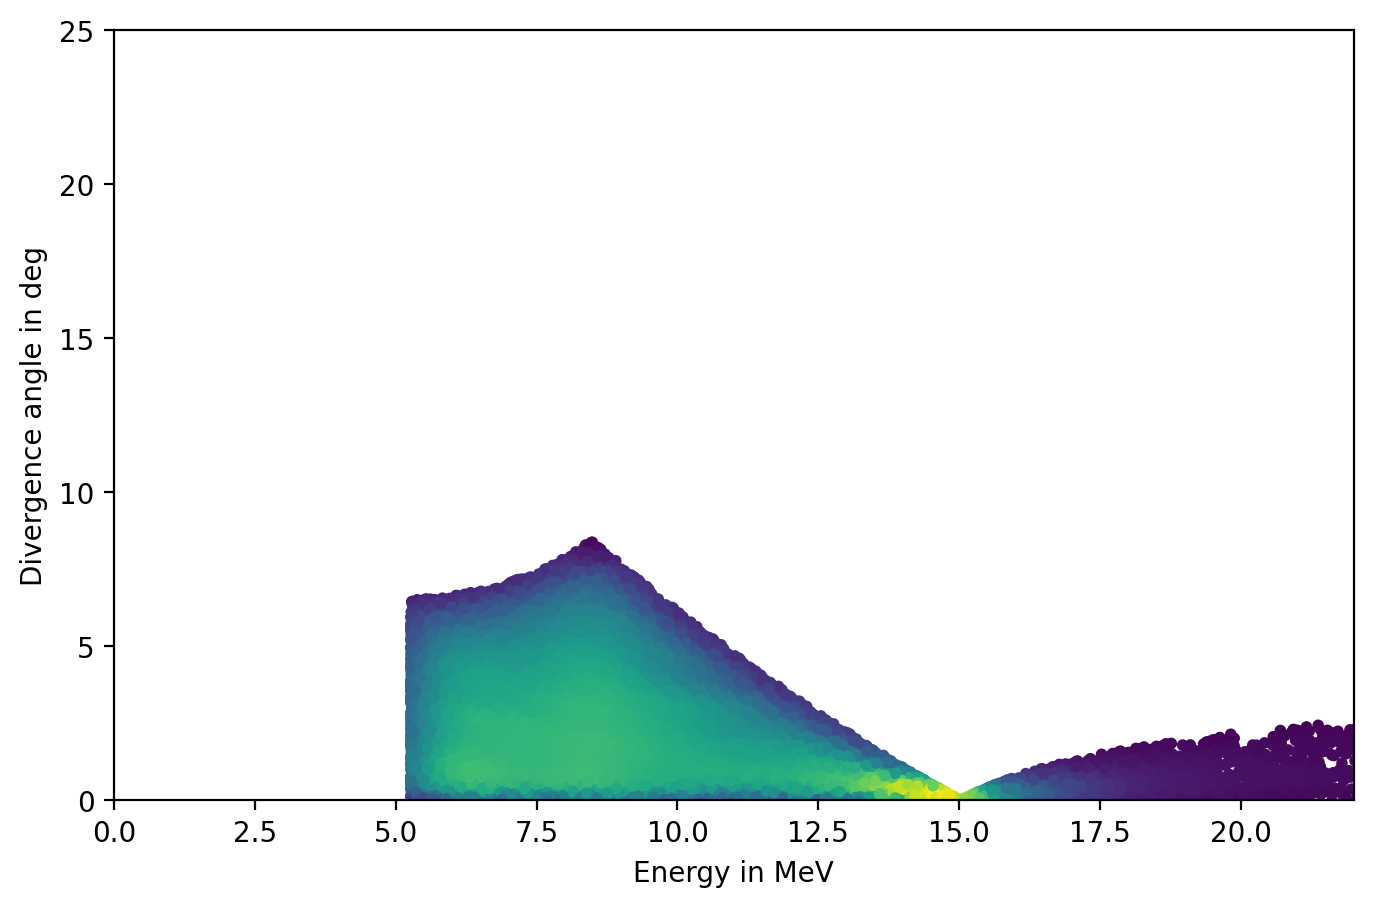

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde

ref_beta = CMethods.beta(reference_energy)
ref_mom = 93450443.2676332

#print(len(test_beam.bunch_list[0]))

test_bunch_nump = test_beam.bunch_list[450].detach().numpy()

print(len(test_bunch_nump.T[0]))

p_x = test_bunch_nump.T[1]*ref_mom
p_tot = (ref_mom*test_bunch_nump.T[5]/ref_beta)+ref_mom

x_beta = CMethods.E_kin(ref_beta+test_bunch_nump.T[5])
div_angle = (180*np.arctan(abs(p_x/p_tot)))/np.pi



#plt.scatter(CMethods.E_kin(ref_beta+test_bunch_nump.T[5]), (180*np.arctan(abs(p_x/p_tot)))/np.pi)

xy = np.vstack([x_beta,div_angle])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_beta, div_angle, c=z, s=10)
ax.set_xlabel("Energy in MeV")
ax.set_ylabel("Divergence angle in deg")
ax.set_ylim([0,25])
ax.set_xlim([0,22])
plt.show()

In [166]:
import numpy as np
import scipy as sp
#print(test_beam.bunch_list[-1][:10])

numpy_bunch_output = test_beam.bunch_list[-1].detach().numpy()

print(numpy_bunch_output.shape)
print(numpy_bunch_output[0][5])

reference_energy = 11.006966504345655
upper_energy_limit = 1.002 * reference_energy
lower_energy_limit = 0.998 * reference_energy

upper_energy_beta = CMethods.beta(upper_energy_limit, "proton")
lower_energy_beta = CMethods.beta(lower_energy_limit, "proton")

upper_delta_beta = upper_energy_beta - reference_beta
lower_delta_beta = lower_energy_beta - reference_beta

mask_0 = numpy_bunch_output[:,5] < upper_delta_beta
filter_0 = numpy_bunch_output[mask_0]
mask_1 = filter_0[:, 5] > lower_delta_beta
numpy_bunch_filtered = filter_0[mask_1]

print(upper_delta_beta)
print(lower_delta_beta)
print(len(numpy_bunch_filtered))

print((np.max(numpy_bunch_filtered.T[4])-min(numpy_bunch_filtered.T[4]))/sp.constants.speed_of_light*10**9)

#print(upper_delta_beta)
#print(lower_delta_beta)

filtered_eps_x = np.sqrt(np.mean(numpy_bunch_filtered[:,0]**2)*np.mean(numpy_bunch_filtered[:,1]**2)-np.square(np.mean(numpy_bunch_filtered[:,0]*numpy_bunch_filtered[:,1])))

filtered_eps_y = np.sqrt(np.mean(numpy_bunch_filtered[:,2]**2)*np.mean(numpy_bunch_filtered[:,3]**2)-np.square(np.mean(numpy_bunch_filtered[:,2]*numpy_bunch_filtered[:,3])))

emit_mmmrad_x = 10**6 * filtered_eps_x
emit_mmmrad_norm_x = beta_ref*gamma_ref*emit_mmmrad_x
emit_mmmrad_norm_2sigma_x =4 * emit_mmmrad_norm_x

emit_mmmrad_y = 10**6 * filtered_eps_y
emit_mmmrad_norm_y = beta_ref*gamma_ref*emit_mmmrad_y
emit_mmmrad_norm_2sigma_y =4 * emit_mmmrad_norm_y

print(emit_mmmrad_norm_2sigma_x)
print(emit_mmmrad_norm_2sigma_y)


(9999, 6)
0.003834908603771681
0.00014912687984086626
-0.00014928387558985068
3796
2.0898323616810726
nan
1.5436882226358017e-09


/var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/ipykernel_97782/3585903190.py:34: RuntimeWarning: invalid value encountered in sqrt
  filtered_eps_x = np.sqrt(np.mean(numpy_bunch_filtered[:,0]**2)*np.mean(numpy_bunch_filtered[:,1]**2)-np.square(np.mean(numpy_bunch_filtered[:,0]*numpy_bunch_filtered[:,1])))


In [193]:
import scipy as sp

dist_to_cav_in = 1.225
f_cavity = 108.4 * 10**6

t_phase_cav = 1/f_cavity
t_comp_phase = t_phase_cav/2

ref_point = 9
ref_point_beta = CMethods.beta(ref_point, "proton")
ref_point_v = sp.constants.speed_of_light*ref_point_beta

t_ref_point = dist_to_cav_in/ref_point_v


t_ref_point_upper = t_ref_point + t_comp_phase/2
t_ref_point_lower = t_ref_point - t_comp_phase/2

beta_ref_point_upper = (dist_to_cav_in/t_ref_point_upper)/sp.constants.speed_of_light
beta_ref_point_lower = (dist_to_cav_in/t_ref_point_lower)/sp.constants.speed_of_light

ref_point_upper = CMethods.E_kin(beta_ref_point_upper, "proton")
ref_point_lower = CMethods.E_kin(beta_ref_point_lower, "proton")

print(ref_point_lower)
print(ref_point_upper)



10.605266734937231
7.7347043330033785


In [51]:
import scipy as sp

v = CMethods.beta(ref_energy)*sp.constants.speed_of_light
delta_t = min(test_beam.bunch_list[-1][:, 4].detach().numpy())

t_soll = 5.4/v
t_langsam = t_soll + delta_t/sp.constants.speed_of_light

v_langsam = 5.4/t_langsam
beta_langsam = v_langsam/sp.constants.speed_of_light

e_kin_langsam = CMethods.E_kin(beta_langsam)

print(e_kin_langsam)



10.980636308117596


In [215]:
print(torch.mean(test_beam.bunch_list[0][:, 5]))
print(torch.std(test_beam.bunch_list[0][:, 5]))
print(torch.mean(test_beam.bunch_list[-1][:, 5]))
print(torch.std(test_beam.bunch_list[-1][:, 5]))

print(len(test_beam.bunch_list[-1]))




tensor(8.2655e-18, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0091, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(-0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<StdBackward0>)
317


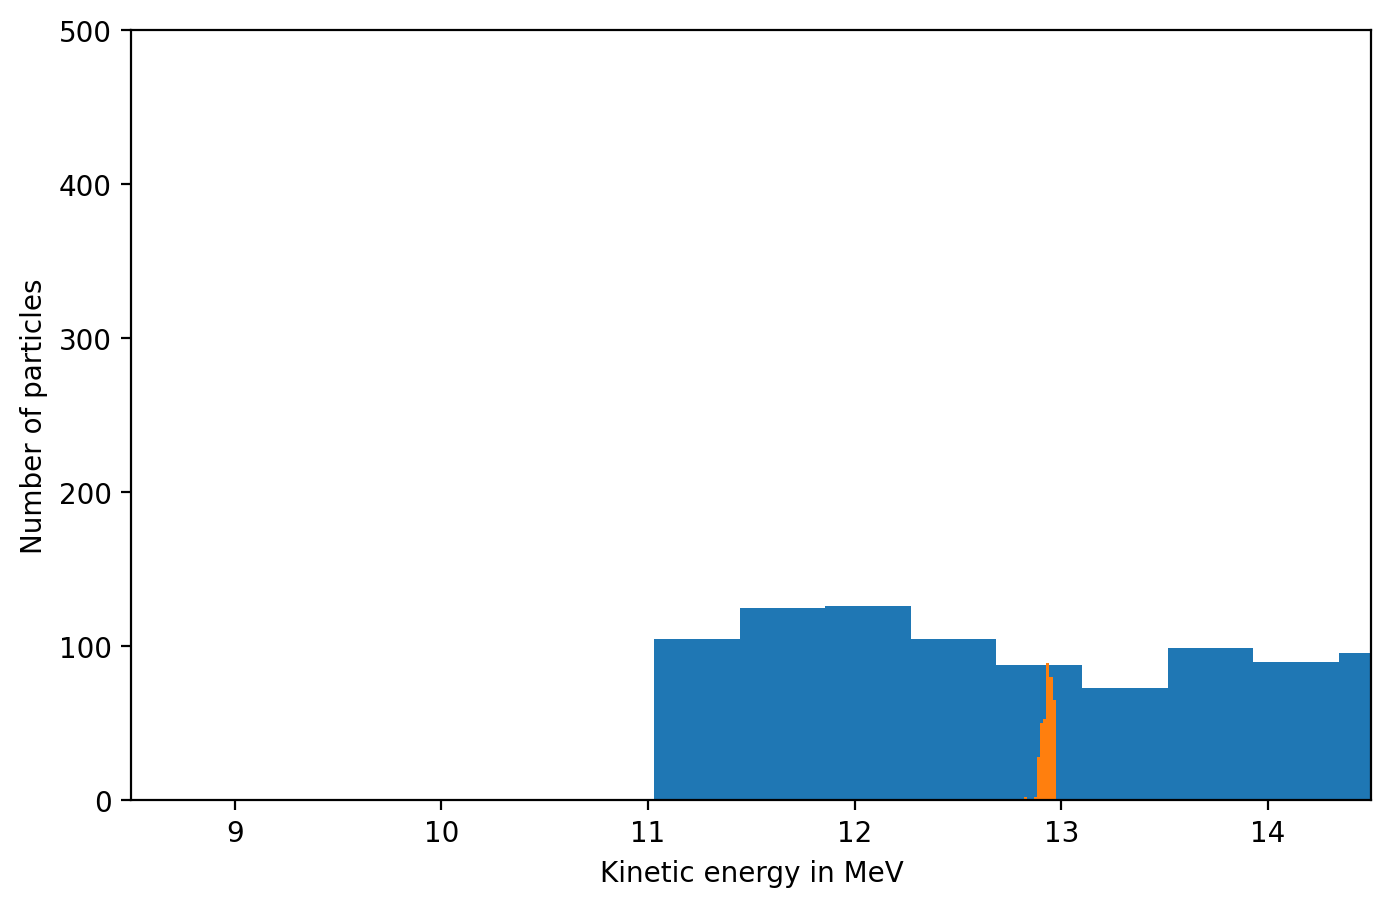

In [118]:
import matplotlib.pyplot as plt

plt.hist(CMethods.E_kin((reference_beta) + test_beam.bunch_list[0][:, 5].detach().numpy(), "proton"))
plt.hist(CMethods.E_kin((reference_beta) + test_beam.bunch_list[-1][:, 5].detach().numpy(), "proton"))

plt.ylim([0, 500])
plt.xlim([8.5, 14.5])
plt.xlabel("Kinetic energy in MeV")
plt.ylabel("Number of particles")

plt.show() 

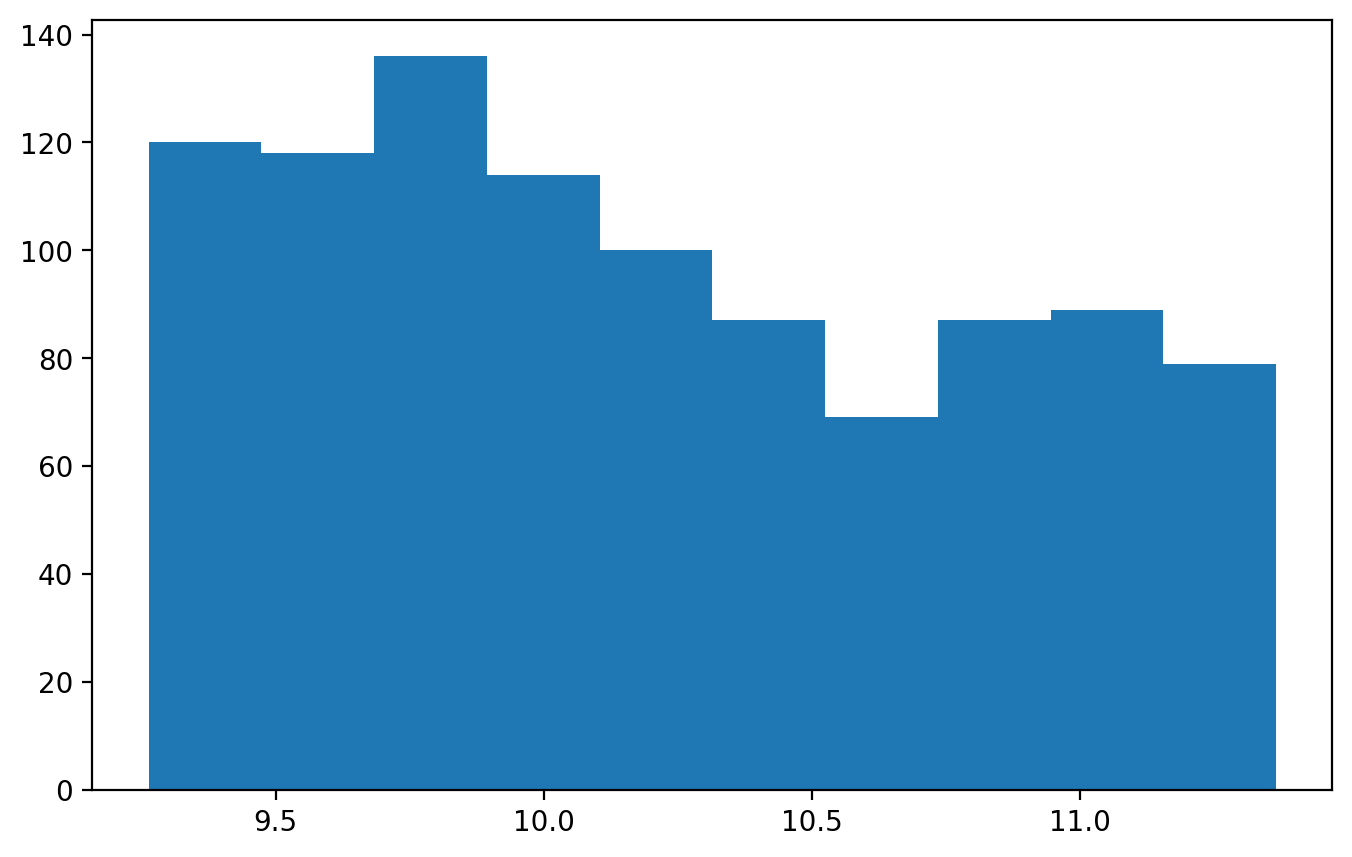

In [188]:

plt.hist(CMethods.E_kin(0.14625366891072414+test_beam.bunch_list[0][:, 5].detach().numpy(), "proton"))
plt.show() 

In [72]:
print(CMethods.beta(10.5,"proton"))
print(CMethods.beta(9.5,"proton"))

print(test_beam.bunch_list[-1][:, 5])
print(test_beam.bunch_list[-1][:, 4])

0.14836237721506962
0.1412322306451742
tensor([-5.1372e-04, -6.7116e-04, -5.3018e-03, -6.8485e-03,  3.9995e-03,
         6.5750e-03, -5.1900e-03, -1.8848e-03,  3.9997e-03,  3.5237e-03,
         1.2889e-03,  5.1792e-03, -5.5457e-03,  7.5364e-03, -2.9377e-03,
         3.8877e-03, -3.5476e-03,  3.7332e-04, -1.1843e-03,  3.6024e-03,
        -5.4693e-03, -2.8420e-03, -5.5874e-03,  1.5164e-03, -2.8560e-03,
         2.0163e-03, -6.7008e-03,  7.5365e-03, -3.8542e-03, -7.9030e-04,
         4.3126e-03, -8.3245e-04,  4.6869e-03, -3.5330e-03, -1.1406e-03,
         2.5040e-03, -7.2355e-04, -2.8423e-03,  1.1186e-03,  8.9401e-04,
         1.7172e-03, -6.7470e-03, -6.7642e-03, -1.4026e-03, -5.8431e-04,
         5.9153e-03,  6.8806e-03, -1.4883e-04,  9.0201e-04, -1.4467e-03,
         4.6288e-03, -4.5998e-03,  3.3788e-03,  6.6942e-03, -2.4345e-03,
        -4.9425e-03, -4.8488e-03,  5.9403e-03,  6.2037e-03, -6.1656e-03,
         2.7053e-03,  6.7432e-03,  1.8957e-03,  1.1071e-03, -6.7398e-03,
        -2.6

In [156]:
print(CMethods.E_kin(0.11547182785021626))

6.318598061617308


In [93]:
#testing if elements 5 (-delta t * c) and 6 (beta_s*(delta p / p_s)) of phase space vector are correct

import scipy as sp

t_vector = test_beam.bunch_list[-1][:, 4]
delta_t_vector = test_beam.bunch_list[-1][:, 5]

c = sp.constants.speed_of_light
beta_ref = 0.14625366891072414

for count,ts in enumerate(t_vector):
    

    dummy_0 = delta_t_vector[count]
    dummy_1 = ts
    t = -dummy_1/c
    beta_cus = beta_ref+(dummy_0)

    v_cus = beta_cus*c
    v_ref = beta_ref*c

    t_cus = 5.4/v_cus
    t_ref = 5.4/v_ref
    delta_t = t_cus-t_ref
    
    print(count)
    print(f"Error {torch.round(100*(t-delta_t)/t)}")


#indx = 952
indx = 679


dummy_0 = delta_t_vector[indx]
dummy_1 = t_vector[indx]
t = -dummy_1/c
beta_cus = beta_ref+(dummy_0)

v_cus = beta_cus*c
v_ref = beta_ref*c

t_cus = 5.4/v_cus
t_ref = 5.4/v_ref
delta_t = t_cus-t_ref

print(t, delta_t)
print(test_beam.bunch_list[0][indx])
print(test_beam.bunch_list[-1][indx])

0
Error 7.0
1
Error 1.0
2
Error -3.0
3
Error -4.0
4
Error 1.0
5
Error 4.0
6
Error -4.0
7
Error 1.0
8
Error 1.0
9
Error 2.0
10
Error -1.0
11
Error 3.0
12
Error -4.0
13
Error 4.0
14
Error -1.0
15
Error 2.0
16
Error -2.0
17
Error -8.0
18
Error 3.0
19
Error 1.0
20
Error -3.0
21
Error -2.0
22
Error -3.0
23
Error -1.0
24
Error -2.0
25
Error -0.0
26
Error -4.0
27
Error 4.0
28
Error -3.0
29
Error 4.0
30
Error 2.0
31
Error 2.0
32
Error 2.0
33
Error -2.0
34
Error 1.0
35
Error -1.0
36
Error 1.0
37
Error -1.0
38
Error -1.0
39
Error -3.0
40
Error -2.0
41
Error -5.0
42
Error -5.0
43
Error 3.0
44
Error 4.0
45
Error 3.0
46
Error 4.0
47
Error 20.0
48
Error -3.0
49
Error 1.0
50
Error 2.0
51
Error -2.0
52
Error 1.0
53
Error 4.0
54
Error -0.0
55
Error -3.0
56
Error -3.0
57
Error 3.0
58
Error 4.0
59
Error -4.0
60
Error -0.0
61
Error 3.0
62
Error -1.0
63
Error -4.0
64
Error -5.0
65
Error -2.0
66
Error -4.0
67
Error -2.0
68
Error 1.0
69
Error 92.0
70
Error -0.0
71
Error 12.0
72
Error 1.0
73
Error 1.0
74
Erro

In [ ]:
import torch

initial_particles = test_beam.bunch_list[0].size(0)
output_count = test_beam.bunch_list[-1].size(0)

trm = torch.div(output_count, initial_particles)

print(trm)

In [190]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

test_particles_xyz = elements.Beam("ltt_beam_export.part")


#elements.toy_model(params[0][0], params[0][1], params[0][2], 
#                             params[0][3], params[0][4], params[0][5], test_particles_xyz)

x_list = []
y_list = []
z_list = []
div_list = []

pic_indx = 0

for parameter in params[:]:
    elements.toy_model(parameter[0], parameter[1], parameter[2], parameter[3], parameter[4], parameter[5], test_particles_xyz)
    x_list.append(test_particles_xyz.rms_x.detach().numpy())
    y_list.append(test_particles_xyz.rms_y.detach().numpy())
    z_list.append(test_particles_xyz.z_pos.detach().numpy())
    
    #plt.clf()
    #plt.hist(CMethods.E_kin(0.14625366891072414+test_particles_xyz.bunch_list[-1][:,5].detach().numpy(), "proton"))

    #plt.xlim([7.5, 11])
    #plt.ylim([0, 300])
    #plt.xlabel("Kinetic energy in MeV")
    #plt.ylabel("Number of particles")

    #plt.savefig("histograms/pic_" + str(pic_indx) + ".png", bbox_inches='tight') 
    
    #pic_indx += 1
    
    test_particles_xyz.reset_beam()



KeyboardInterrupt: 

In [168]:
print(CMethods.beta(11) - CMethods.beta(11.4))

-0.00268652291456567


In [62]:
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.animation import PillowWriter
%matplotlib notebook

matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()

ax.set(xlim=[0, 5.4], ylim=[0, 0.1], xlabel='z [m]', ylabel='x [m]')


plot_zero_x = ax.plot(z_list[0], x_list[0], c="b", label="x_RMS")[0]
plot_zero_y = ax.plot(z_list[0], y_list[0], c="green", label="y_RMS")[0]

ax.axhline(y = 0.02, color = 'black', linestyle = '-', label="Solenoid Aperture")
s0_pos_0 = ax.axvline(x = 0.09, color="orange", linestyle = '-.', label=f"Solenoid position")
s0_pos_1 = ax.axvline(x = 0.39, color="orange", linestyle = '-.')

s1_pos_0 = ax.axvline(x = params[0][2]+0.85+params[0][3], color="orange", linestyle = '-.')
s1_pos_1 = ax.axvline(x = params[0][2]+0.85+params[0][3]+0.3, color="orange", linestyle = '-.')

r0_pos_0 = ax.axvline(x = params[0][2]+0.3, color="red", linestyle = '-.', label=f"Cavity position")
r0_pos_1 = ax.axvline(x = params[0][2]+0.85, color="red", linestyle = '-.')

ax.legend()

def update_anim(i):
    
    plot_zero_x.set_xdata(z_list[i])
    plot_zero_x.set_ydata(x_list[i])
    plot_zero_y.set_xdata(z_list[i])
    plot_zero_y.set_ydata(y_list[i])
    r0_pos_0.set_xdata(params[i][2]+0.3)
    r0_pos_1.set_xdata(params[i][2]+0.85)
    s1_pos_0.set_xdata(params[i][2]+0.85+params[i][3])
    s1_pos_1.set_xdata(params[i][2]+0.85+params[i][3]+0.3)
    s0_pos_0.set_linewidth(np.exp((params[i][0]-min(params[:][0]))/10))
    s0_pos_1.set_linewidth(np.exp((params[i][0]-min(params[:][0]))/10))
    r0_pos_0.set_linewidth(np.exp((params[i][4]-min(params[:][4]))/2))
    r0_pos_1.set_linewidth(np.exp((params[i][4]-min(params[:][4]))/2))
    s1_pos_0.set_linewidth(np.exp((params[i][1]-min(params[:][1]))/10))
    s1_pos_1.set_linewidth(np.exp((params[i][1]-min(params[:][1]))/10))
    
    return plot_zero_x, plot_zero_y

ani = animation.FuncAnimation(fig=fig, func=update_anim, frames=len(y_list), interval=100)

ani.save(filename="pillow_animation.gif", writer="pillow", fps=60)


<IPython.core.display.Javascript object>

/var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/ipykernel_17693/3577334005.py:36: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  r0_pos_0.set_xdata(params[i][2]+0.3)
/var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/ipykernel_17693/3577334005.py:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  r0_pos_1.set_xdata(params[i][2]+0.85)
/var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/ipykernel_17693/3577334005.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  s1_pos_0.set_xdata(params[i][2]+0.85+params[i][3])
/var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/ipykernel_17693/3577334005.py:39: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor release

In [37]:
print(s1_pos_0.set_linewidth(2))

None


In [ ]:
print(len(params[0]))

In [ ]:

a = elements.Solenoid(100, 2000, 0.3, 10)

print(type(a))




In [ ]:
%matplotlib notebook

bild = plt.plot([1,2,3,4],[1,2,3,4])

plt.show()

In [ ]:


theta = 9.7
max_b = elements.thin_shell_solenoid(theta, 0.027, 0, 0.15)

print(max_b)


In [ ]:
test_beam = elements.Beam("ltt_beam_export.part")

a_0 = torch.cat([test_beam.rms_x, test_beam.rms_x])
test_beam.z_pos = torch.cat([test_beam.z_pos, torch.mul(test_beam.z_pos,2)])

a_1 = torch.cat([test_beam.rms_x, torch.tensor([torch.std(test_beam.bunch_list[-1][:,0])])])

print(a_1)



In [ ]:
nums_0 = torch.tensor([1,2,3,4], dtype=torch.float64, requires_grad=True)
nums_1 = torch.tensor([5,6,7,8], dtype=torch.float64, requires_grad=True)

nums_tot_0 = torch.stack((nums_0, nums_1, nums_0))

nums_filt = nums_tot_0[nums_tot_0[:,0] > 2]

print(nums_filt)

In [770]:
import numpy as np
import surrogates
import torch.utils.data as tud
import os


        

beam_training = np.load("Archive/LIGHTbeams/Trial0_Training_Data/training/100000p9_11mev140mrad9.4kA_training.npy")
beam_test = np.load("Archive/LIGHTbeams/Trial0_Training_Data/test/100000p9_11mev140mrad9.4kA_test.npy")

beam_data_0 = surrogates.ParticleDataset(beam_training)
beam_data_1 = surrogates.ParticleDataset(beam_test)

training_data = tud.ConcatDataset([beam_data_0])
test_data = tud.ConcatDataset([beam_data_1])

print(beam_data_0.__getitem__(0))



[9.65317233e-13 9.80973975e-13 9.49342827e-13 ... 9.01096647e-13
 9.30795876e-13 9.38287041e-13]
[9.06825290e-13 9.20386048e-13 9.41301886e-13 ... 9.11322420e-13
 9.75356883e-13 9.54008459e-13]
(tensor([ 0.9306,  0.9306,  0.9306, -1.3697,  0.0387,  0.9225,  1.0000]), tensor([-0.7165, -0.8121,  0.8556, -1.0634, -1.0469,  0.9284]))


In [1283]:
training_data = surrogates.dir_to_dataset_list("Archive/LIGHTbeams/Trial0_Training_Data/training/240608")
test_data = surrogates.dir_to_dataset_list("Archive/LIGHTbeams/Trial0_Training_Data/test/240608")

test_data_bunched = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=True)

#training_data = tud.ConcatDataset(temp_tr_dataset_list)
#test_data = tud.ConcatDataset(temp_te_dataset_list)


(tensor([ 0.9201,  0.9201,  0.9201, -0.5757, -0.4242,  0.1977,  0.9693]), tensor([-1.0853e+00, -1.7928e-01,  1.5992e-04, -1.0747e+00, -1.9011e-01,
         1.9374e-01]))
(tensor([ 0.8973,  0.8973,  0.8973, -0.1624, -0.7387,  0.0175, -0.0297]), tensor([-0.8512, -1.2870,  0.1705, -1.0640, -0.8805,  0.0245]))


In [780]:
import pickle

file = open("Archive/LIGHTbeams/Trial0_Training_Data/picklejar/100000p_9_11mev_140mrad_9_11ka_test.pickle", "wb")
pickle.dump(test_data, file)
file.close()

file = open("Archive/LIGHTbeams/Trial0_Training_Data/picklejar/100000p_9_11mev_140mrad_9_11ka_training.pickle", "wb")
pickle.dump(training_data, file)
file.close()


In [1290]:
from torch import nn
import custom_loss

model = surrogates.SolenoidSurrogate()

learning_rate = 1e-3
batch_size = 1000
epochs = 10


# file_open = open("Archive/LIGHTbeams/Trial0_Training_Data/picklejar/100000p_9_11mev_140mrad_9_11ka_training.pickle", "rb")
# training_data = pickle.load(file_open)
# file_open.close()
# 
# file_open = open("Archive/LIGHTbeams/Trial0_Training_Data/picklejar/100000p_9_11mev_140mrad_9_11ka_test.pickle", "rb")
# test_data = pickle.load(file_open)
# file_open.close()
# 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

#loss_fn = nn.MSELoss()
loss_fn = custom_loss.WMSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [1291]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg test loss: {test_loss:>8f} \n")
    


In [1209]:
import sys

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.828500  [ 1000/3200000]
loss: 0.282025  [101000/3200000]
loss: 0.196005  [201000/3200000]
loss: 0.173556  [301000/3200000]
loss: 0.162660  [401000/3200000]
loss: 0.184260  [501000/3200000]
loss: 0.182925  [601000/3200000]


KeyboardInterrupt: 

In [1149]:
surrogates.mean_max_error(model, test_dataloader)





Test Errors:
_________________________________________________________________________
Average mean: 
x: 59.4 %, y: 177.9 %, t: 5.3 %, p_x: 25.1 %, p_y: 18.6 %, p_z: 5.2 %
Average max per batch: 
x: 2783.5 %, y: 14660.5 %, t: 12.0 %, p_x: 1303.1 %, p_y: 660.9 %, p_z: 11.2 %


array([0.36218467, 0.35508674, 0.05358278, 0.12558405, 0.14085765,
       0.05386893])

In [1310]:
learning_rate = 1e-3
#loss_fn.weight = torch.tensor([1,1,1,1,1,1])

#x_error_list = np.array([])
#y_error_list = np.array([])
#t_error_list = np.array([])
#px_error_list = np.array([])
#py_error_list = np.array([])
#pz_error_list = np.array([])

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs_epochs = 2
for s in range(epochs_epochs):
    epochs = 5
    for t in range(epochs):
        print(f"\nEpoch epoch {s+1}")
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
    print("Done!")

    mean_array = surrogates.mean_max_error(model, test_dataloader)
    x_error_list = np.append(x_error_list, mean_array[0])
    y_error_list = np.append(y_error_list, mean_array[1])
    t_error_list = np.append(t_error_list, mean_array[2])
    px_error_list = np.append(px_error_list, mean_array[3])
    py_error_list = np.append(py_error_list, mean_array[4])
    pz_error_list = np.append(pz_error_list, mean_array[5])
    max_val = max(mean_array)
    mean_array = mean_array/max_val
    loss_fn.weight = torch.tensor([mean_array[0], mean_array[1], mean_array[2], 
                                   mean_array[3], mean_array[4], mean_array[5]])

    print(loss_fn.weight)


Epoch epoch 1
Epoch 1
-------------------------------
loss: 0.001671  [ 1000/10010000]
loss: 0.001814  [101000/10010000]
loss: 0.001575  [201000/10010000]
loss: 0.001589  [301000/10010000]
loss: 0.001080  [401000/10010000]
loss: 0.000985  [501000/10010000]
loss: 0.001267  [601000/10010000]
loss: 0.001322  [701000/10010000]
loss: 0.001700  [801000/10010000]
loss: 0.001580  [901000/10010000]
loss: 0.001323  [1001000/10010000]
loss: 0.001326  [1101000/10010000]
loss: 0.001171  [1201000/10010000]
loss: 0.001217  [1301000/10010000]
loss: 0.001642  [1401000/10010000]
loss: 0.001550  [1501000/10010000]
loss: 0.001112  [1601000/10010000]
loss: 0.001729  [1701000/10010000]
loss: 0.000998  [1801000/10010000]
loss: 0.001276  [1901000/10010000]
loss: 0.001522  [2001000/10010000]
loss: 0.001118  [2101000/10010000]
loss: 0.001617  [2201000/10010000]
loss: 0.001491  [2301000/10010000]
loss: 0.001370  [2401000/10010000]
loss: 0.001574  [2501000/10010000]
loss: 0.001677  [2601000/10010000]
loss: 0.001

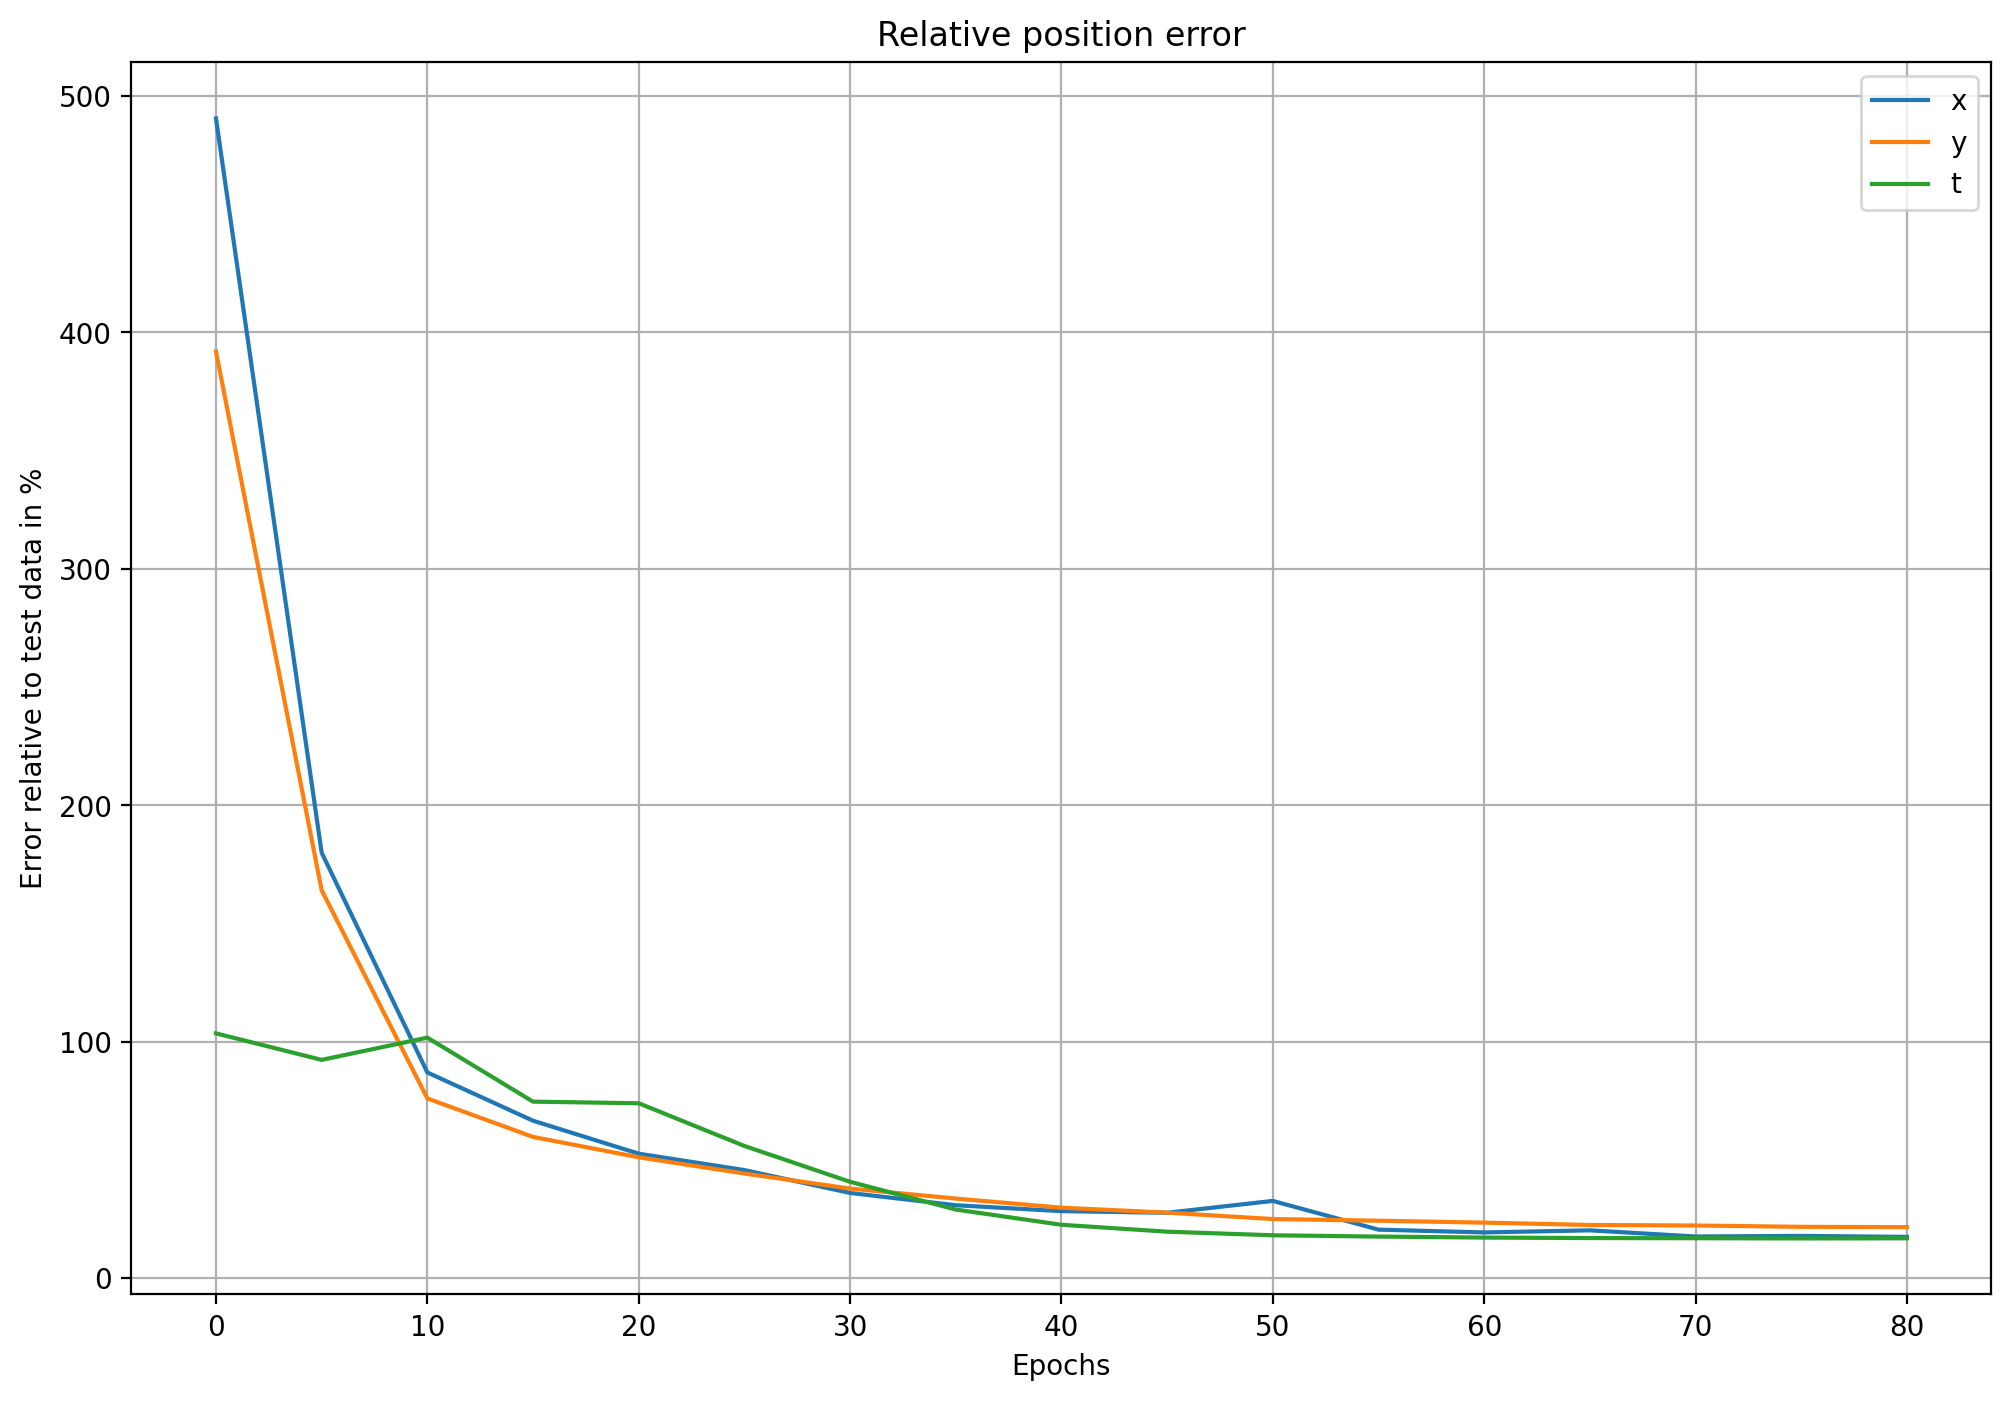

In [1322]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'


eps = np.arange(0,17)

plt.plot(5*eps, x_error_list*100)
plt.plot(5*eps, y_error_list*100)
plt.plot(5*eps, t_error_list*100)

plt.legend(['x', 'y', 't'])
plt.ylabel("Error relative to test data in %")
plt.xlabel("Epochs")
plt.title("Relative position error")
plt.grid()

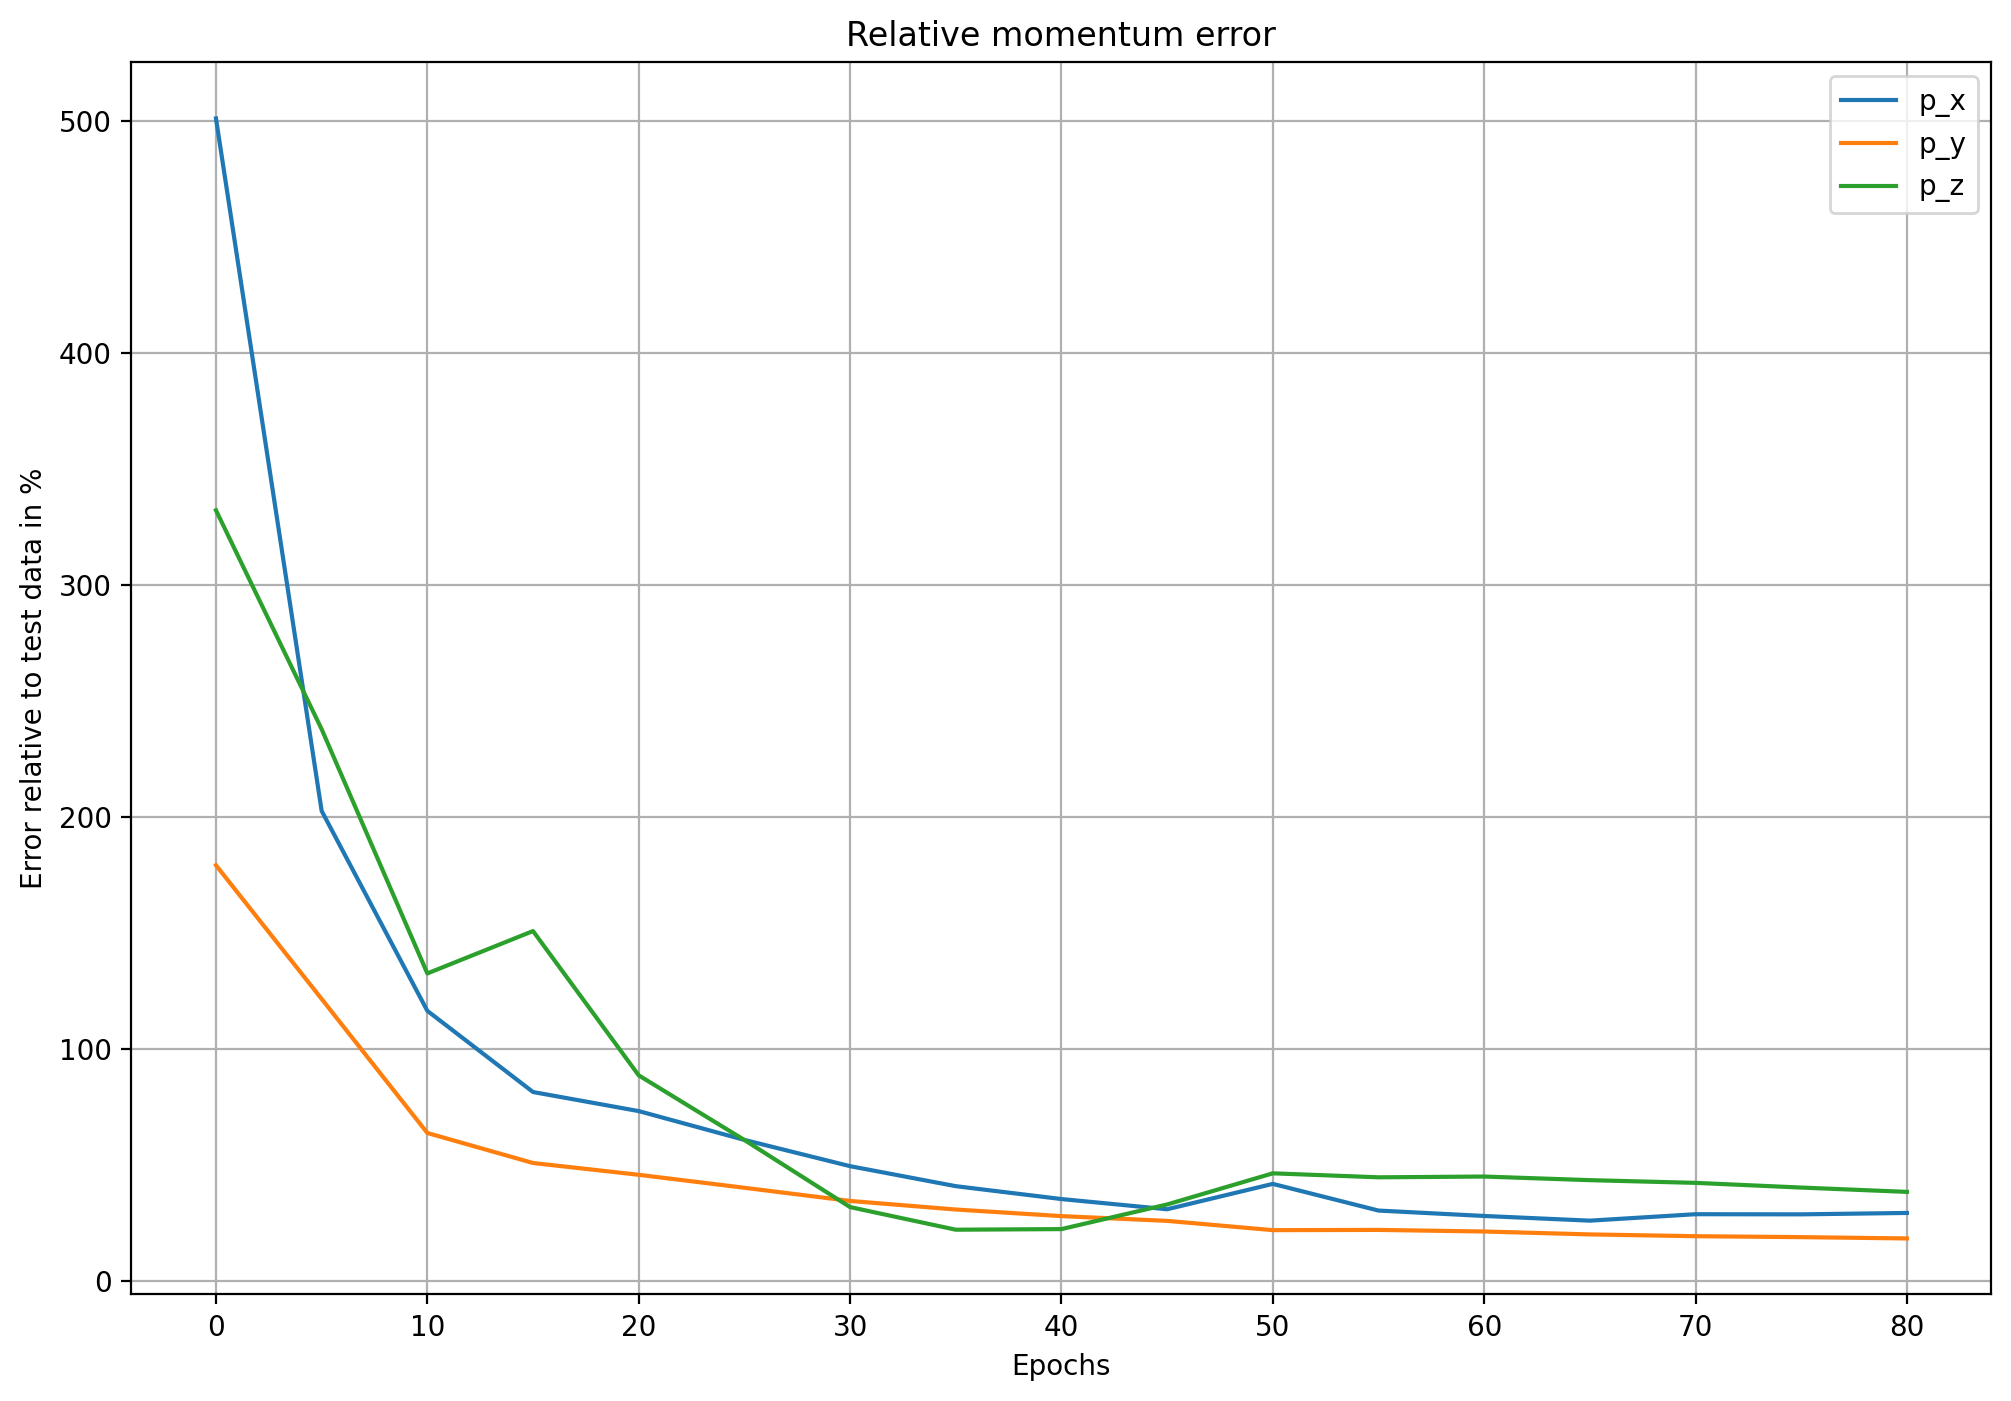

In [1323]:
plt.plot(5*eps, px_error_list*100)
plt.plot(5*eps, py_error_list*100)
plt.plot(5*eps, pz_error_list*100)

plt.legend(['p_x', 'p_y', 'p_z'])
plt.ylabel("Error relative to test data in %")
plt.xlabel("Epochs")
plt.title("Relative momentum error")
plt.grid()

In [1329]:
total_list = np.array([x_error_list, y_error_list, t_error_list, px_error_list, py_error_list, pz_error_list])

np.save("Archive/pickles/export/model005_rev2_errors_5x16_eps.npy", total_list, )


In [1317]:


file = open("Archive/pickles/export/model005_rev2.pickle", "wb")
pickle.dump(model, file)
file.close()


In [1318]:

file = open("Archive/pickles/export/model005_trdata.pickle", "wb")
pickle.dump(training_data, file)
file.close()

file = open("Archive/pickles/export/model005_tedata.pickle", "wb")
pickle.dump(test_data, file)
file.close()


In [1327]:
print(training_data.in_max_list)
print(training_data.out_max_list)

[9.999999993673508e-13, 9.999999993673508e-13, 9.999999993673508e-13, 8909239.51048443, 8896262.343198072, 64026263.69728826, 14.999999999999854]
[0.07119202565482073, 0.07120724187081795, 2.615718890351589e-08, 10955187.108948682, 10969527.532464387, 64027733.68489398, 14.999999999999854]


In [1324]:
training_data_000 = surrogates.dir_to_dataset_list("Archive/LIGHTbeams/Trial0_Training_Data/training/240613", training_data.in_max_list, training_data.out_max_list)

print(training_data.__len__())


(tensor([ 0.9517,  0.9517,  0.9517, -0.5757, -0.4272,  0.1977,  0.9693]), tensor([-1.0853e+00, -1.7928e-01,  1.5992e-04, -1.0747e+00, -1.9011e-01,
         1.9374e-01]))
10010000


In [218]:
dummy_4 = 0.36

dummy_2 = CMethods.beta(8, "proton")

dummy_3 = sp.constants.speed_of_light*dummy_2

dummy_5 = dummy_4 / dummy_3

print(dummy_5)

dummy_6 = 108.4 * 10 ** (6)

print(1/dummy_6)

9.254429966368601e-09
9.225092250922509e-09


In [1326]:
print(training_data_000.in_max_list)
print(training_data_000.out_max_list)

[9.999999938707681e-13, 9.999999938707681e-13, 9.999999938707681e-13, 8909239.51048443, 8943632.693993006, 64026263.69728826, 14.99999999999997]
[0.07119202565482073, 0.07120724187081795, 2.615718890351589e-08, 10955187.108948682, 10969527.532464387, 64027733.68489398, 14.99999999999997]


In [1330]:
file = open("Archive/LIGHTbeams/Trial0_Training_Data/picklejar/test_data_000.pickle", "wb")
pickle.dump(test_data, file)
file.close()

In [1331]:
print(test_data.out_max_list)



[0.07125033558156368, 0.07125340889245838, 2.61519447482496e-08, 10878660.62616183, 10780162.546653992, 64027582.0133755, 14.994999999999788]


In [1332]:
print(training_data.in_max_list)

[9.999999993673508e-13, 9.999999993673508e-13, 9.999999993673508e-13, 8909239.51048443, 8896262.343198072, 64026263.69728826, 14.999999999999854]


In [3]:
print(round(5,111)%5)

0


1.602176634e-19
43423140.02348509


In [20]:
import CMethods
import scipy as sp
import numpy as np

v_min = sp.constants.speed_of_light*CMethods.beta(2)
v_max = sp.constants.speed_of_light*CMethods.beta(22)
v_avg = (v_max+v_min)/2

d_target = 0.04

t_max = d_target/v_min
t_min = d_target/v_max

d_min = t_min*v_min
d_max = t_min*v_max

delta_d = d_max-d_min

print(t_max, t_min)
print(delta_d)

2.046760978952333e-09 6.269196754362644e-10
0.027748062780497934


In [94]:
#1/108.4*10**(-6)

mu_0 * 200000

0.251327412424

In [79]:
beta_10 = CMethods.beta(10, "proton")
v_beta_10 = sp.constants.speed_of_light*beta_10
mu_0 = sp.constants.mu_0
p_charge = sp.constants.elementary_charge
n_p = 10**10

I_10_MeV = (n_p*p_charge*v_avg)/delta_d

B_10_MeV = (mu_0*I_10_MeV)/(2*np.pi)

print(I_10_MeV)



344.4030127554672


In [82]:
E_vector = np.arange(2,21,1)
n_vector = CMethods.tnsa_p_dist_fit(E_vector, 1.61*10**11, 10.35)
v_avg = np.zeros(len(E_vector)-1)
delta_d = np.zeros(len(E_vector)-1)
N_vector_new = np.zeros(len(E_vector)-1)



i = 0

while i < len(E_vector)-1:
    v_min = sp.constants.speed_of_light*CMethods.beta(E_vector[i])
    v_max = sp.constants.speed_of_light*CMethods.beta(E_vector[i+1])
    v_avg[i] = (v_max+v_min)/2
    
    d_target = 0.004

    t_max = d_target/v_min
    t_min = d_target/v_max

    d_min = t_max*v_min
    d_max = t_max*v_max

    delta_d[i] = d_max-d_min
    
    N_vector_new[i] = n_vector[i]
    
    i += 1

I_spectrum = (N_vector_new*p_charge*v_avg)/delta_d
B_spectrum = (mu_0*I_spectrum)/(2*np.pi)

print(I_spectrum)



[258.09329915 269.42102054 273.13906029 271.59031275 266.3900438
 258.66617312 249.22667101 238.66216644 227.41040952 215.79847675
 204.07149798 192.41286765 180.95886004 169.80943824 159.03639601
 148.68958283 138.80172129 129.3921714 ]


In [25]:
beta_zeit = CMethods.beta(11)
v_zeit = sp.constants.speed_of_light * beta_zeit

beta_zeit_0 = CMethods.beta(9)
v_zeit_0 = sp.constants.speed_of_light * beta_zeit_0

print(1/v_zeit)
print(1/v_zeit_0-1/v_zeit)

2.1974808721115175e-08
2.2809256076083793e-09


In [1]:
import h5py

f = h5py.File('Bfields.h5', 'r')

In [2]:
print(f.keys())

<KeysViewHDF5 ['Bfield_CAD', 'Bfield_SRW', 'Espec_CK', 'Espec_JH', 'double_dipole', 'realistic_coil', 'rev_realistic_coil_revI', 'ring_winding_coil', 'super_duper_coil']>


In [109]:
import matplotlib.pyplot as plt
import matplotlib
import elements
import numpy as np

b_field = []

for i in range(f["ring_winding_coil"].shape[1]):
    
    b_field.append(f["ring_winding_coil"][2][i][20][20])





z = np.linspace(0, .48, 651)

np_bfield = np.array([z, b_field])
np_transpose_bifield = np_bfield.T

print(np_transpose_bifield)

[[0.00000000e+00 4.74609711e-07]
 [7.38461538e-04 4.79326933e-07]
 [1.47692308e-03 4.84107815e-07]
 ...
 [4.78523077e-01 4.84107815e-07]
 [4.79261538e-01 4.79326933e-07]
 [4.80000000e-01 4.74609711e-07]]


In [239]:
import matplotlib.pyplot as plt
import matplotlib
import elements
import numpy as np
import pandas as pd


e_field = []



df = pd.read_csv('cavity_fit.csv', header=None, delimiter="\t")

print(len(df.to_numpy())) 

for effe in df.to_numpy():
    
    e_field.append(effe[1])





z = np.linspace(0, .38, 377)

np_bfield = np.array([z, e_field])
np_transpose_efield = np_bfield.T

print(np_transpose_efield)

377
[[ 0.00000000e+00  1.38000000e-01]
 [ 1.01063830e-03  2.46000000e-01]
 [ 2.02127660e-03  3.91000000e-01]
 [ 3.03191489e-03  5.18000000e-01]
 [ 4.04255319e-03  6.44000000e-01]
 [ 5.05319149e-03  7.52000000e-01]
 [ 6.06382979e-03  9.33000000e-01]
 [ 7.07446809e-03  1.07700000e+00]
 [ 8.08510638e-03  1.22200000e+00]
 [ 9.09574468e-03  1.43800000e+00]
 [ 1.01063830e-02  1.58300000e+00]
 [ 1.11170213e-02  1.90800000e+00]
 [ 1.21276596e-02  2.19700000e+00]
 [ 1.31382979e-02  2.45000000e+00]
 [ 1.41489362e-02  2.73900000e+00]
 [ 1.51595745e-02  3.06400000e+00]
 [ 1.61702128e-02  3.46100000e+00]
 [ 1.71808511e-02  3.75000000e+00]
 [ 1.81914894e-02  4.14800000e+00]
 [ 1.92021277e-02  4.47300000e+00]
 [ 2.02127660e-02  4.83400000e+00]
 [ 2.12234043e-02  5.15900000e+00]
 [ 2.22340426e-02  5.48400000e+00]
 [ 2.32446809e-02  5.81000000e+00]
 [ 2.42553191e-02  6.04400000e+00]
 [ 2.52659574e-02  6.35100000e+00]
 [ 2.62765957e-02  6.60400000e+00]
 [ 2.72872340e-02  6.71300000e+00]
 [ 2.82978723e-0

In [254]:
np.savetxt("cav_fit_rescaled.csv", np_transpose_efield, delimiter="  ")